First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [40]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from sklearn.preprocessing import StandardScaler # we had to manually instal scikit-learn because we need to use it for ML and it is not in requirements.txt
from starvers.starvers import TripleStoreEngine
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [2]:
#executed_by ='stud-id_12332263'  # Replace the digits after "id_" with your own student ID
executed_by ='stud-id_12424821'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [3]:
# group id for this project
group_id = '008'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12332263'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12424821'  # Replace the digits after "id_" with student B's student ID

In [4]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [5]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [6]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [7]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [8]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Milica" .',
f':{student_a} foaf:familyName "Aleksic" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12424821"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Vidak" .',
f':{student_b} foaf:familyName "Grujic" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12332263"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [9]:

supermarket_data_path = os.path.join("dataset_supermarket_analysis", "supermarket_analysis.csv")

## Business Understanding 

In [10]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [11]:
#############################################
# Documentation
#############################################
data_src_and_scenario_comment = """
The dataset is the Supermarket Sales dataset. It contains transaction-level data including
branch, customer type, gender, product line, payment method, unit price, quantity, tax, total sales, date, time,
and a customer satisfaction rating (4 to 10). Scenario: The supermarket chain wants to monitor customer satisfaction
and predict the rating a customer is likely to give. The business particularly wants to detect low predicted ratings
early to improve service quality and customer experience.
"""
#business_objectives_comment ="""..."""
#business_success_criteria_comment = """..."""
#data_mining_goals_comment = """..."""
#data_mining_success_criteria_comment = """..."""
#ai_risk_aspects_comment = """..."""



business_objectives_comment = """
The primary business objectives are:
1. Understand which factors affects customer satisfaction.
2. Predict customer ratings based on available information.
3. Detect scenarios likely to produce low ratings and support decisions to improve service.
"""

business_success_criteria_comment = """
The project will be considered a business success if:
1. The model predicts customer ratings with useful accuracy (e.g., MAE sufficiently low to distinguish low vs. high satisfaction cases).
2. The system can identify transactions likely to result in low ratings, which would enable proactive service improvements.
3. The analysis provides useful insights into factors associated with customer satisfaction.
"""

data_mining_goals_comment = """
The data mining goals are:
1. Train a regression model to predict the continuous customer rating variable.
2. Understand feature importance to identify which attributes most influence satisfaction.
3. Optionally compare multiple ML models.
4. Ensure full reproducibility of all experiments.
"""

data_mining_success_criteria_comment = """
Data mining will be considered successful if:
1. The model achieves meaningful and realistic MAE threshold (e.g., ≤ 1.0).
2. The model is interpretable, allowing business users to understand what determines the low satisfaction.
3. The entire workflow is reproducible and computationally efficient.
"""

ai_risk_aspects_comment = """
Relevant AI risks include:
1. Customer type (Member/Normal) could result in unfair treatment if misused.
2. Using model predictions to treat customers differently could be unethical or discriminatory.
3. Predictions must be used only as decision support and not as a mechanism for unequal service.
"""


bu_ass_uuid_executor = "b976c7cd-08be-4134-9783-22f1c3441a13" 
#bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# uu
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [12]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
load_supermarket_data_code_writer = student_a

def load_supermarket_data() -> pd.DataFrame:
    """
    Load Supermarket Sales dataset for Data Understanding.
    """
    data = pd.read_csv(supermarket_data_path, sep=',', header=0)
    return data



start_time_ld = now()
data = load_supermarket_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.
# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "2434d382-04c0-4aa2-aaf7-23a082327305"  # Generate once
load_supermarket_data_executor = [
    f':load_supermarket_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(load_supermarket_data_executor, prefixes=prefixes)



ld_ass_uuid_writer = "c3662868-04b8-4958-a7ba-d6ccc2849f9f" 

ld_report = """
Load the Supermarket Sales (Extended Version) dataset into a DataFrame for initial Data Understanding, exploration, and quality assessment.
"""

load_supermarket_data_activity = [
    ':load_supermarket_data rdf:type prov:Activity .',
    ':load_supermarket_data sc:isPartOf :data_understanding_phase .',
    ':load_supermarket_data rdfs:comment "Data Understanding" .',
    f':load_supermarket_data rdfs:comment """{ld_report}""" .',
    f':load_supermarket_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_supermarket_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_supermarket_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_supermarket_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # INPUT
    ':load_supermarket_data prov:used :raw_data .',
    ':load_supermarket_data prov:used :supermarket_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':supermarket_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :supermarket_data_path .',

    # OUTPUT
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_supermarket_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_supermarket_data_activity, prefixes=prefixes)

raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name "Supermarket Sales Extended Dataset" .',
    ':raw_data sc:description "Transaction-level supermarket sales data including customer attributes, product information, sales amounts, timestamps, and customer ratings." .',

    ':supermarket_csv rdf:type cr:FileObject .',
    ':supermarket_csv sc:name "supermarket_analysis.csv" .',
    ':supermarket_csv sc:encodingFormat "text/csv" .',
    ':raw_data sc:distribution :supermarket_csv .',

    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name "Supermarket Transaction Table" .',
    ':raw_recordset cr:source :supermarket_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
]
engine.insert(raw_data_triples, prefixes=prefixes)


supermarket_fields = [
    # Identifier
    ('invoice_id', 'Invoice ID', 'Unique identifier for each transaction.', 'xsd:string'),

    # Categorical
    ('branch', 'Branch', 'Supermarket branch where the transaction occurred.', 'xsd:string'),
    ('city', 'City', 'City where the branch is located.', 'xsd:string'),
    ('customer_type', 'Customer type', 'Customer classification: Member or Normal.', 'xsd:string'),
    ('gender', 'Gender', 'Gender of the customer.', 'xsd:string'),
    ('product_line', 'Product line', 'Category of product purchased.', 'xsd:string'),
    ('payment', 'Payment', 'Payment method used in the transaction.', 'xsd:string'),

    # Numeric (monetary & counts)
    ('unit_price', 'Unit price', 'Price per unit of product.', 'xsd:float'),
    ('quantity', 'Quantity', 'Number of items purchased.', 'xsd:integer'),
    ('tax_5', 'Tax 5%', '5 percent tax applied to the purchase.', 'xsd:float'),
    ('sales', 'Sales', 'Total amount paid including tax.', 'xsd:float'),
    ('cogs', 'cogs', 'Cost of goods sold (pre-tax).', 'xsd:float'),
    ('gross_margin_percentage', 'gross margin percentage', 'Gross margin percentage (constant in dataset).', 'xsd:float'),
    ('gross_income', 'gross income', 'Gross income from the transaction.', 'xsd:float'),

    # Temporal
    ('date', 'Date', 'Date of transaction.', 'xsd:date'),
    ('time', 'Time', 'Time of transaction.', 'xsd:string'),

    # Target
    ('rating', 'Rating', 'Customer satisfaction rating on a scale from 4 to 10.', 'xsd:float'),
]

field_triples = []
for f_id, name, desc, dtype in supermarket_fields:
    field_triples.extend([
        f':raw_recordset cr:field :field_{f_id} .',
        f':field_{f_id} rdf:type cr:Field .',
        f':field_{f_id} sc:name "{name}" .',
        f':field_{f_id} sc:description "{desc}" .',
        f':field_{f_id} cr:dataType {dtype} .',
    ])

engine.insert(field_triples, prefixes=prefixes)



data_triples = [
    ':data rdf:type sc:Dataset .',
    ':data sc:name "Loaded Supermarket Sales Dataset" .',
    ':data sc:description "Supermarket transaction data loaded for Data Understanding and exploratory analysis." .',

    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name "Supermarket Sales RecordSet" .',
    ':data cr:recordSet :recordset .',
]

for fid, *_ in supermarket_fields:
    data_triples.append(f':recordset cr:field :field_{fid} .')

engine.insert(data_triples, prefixes=prefixes)




units_triples = [

    # Monetary values (currency unspecified in dataset)
    ':field_unit_price qudt:unit qudt:CurrencyUnit .',
    ':field_tax_5 qudt:unit qudt:CurrencyUnit .',
    ':field_sales qudt:unit qudt:CurrencyUnit .',
    ':field_cogs qudt:unit qudt:CurrencyUnit .',
    ':field_gross_income qudt:unit qudt:CurrencyUnit .',

    # Percentage
    ':field_gross_margin_percentage qudt:unit qudt:Percent .',

    # Counts
    ':field_quantity qudt:unit qudt:CountUnit .',

    # Rating (dimensionless score)
    ':field_rating qudt:unit qudt:DimensionlessUnit .',

    # Temporal
    ':field_date qudt:unit siu:day .',
    ':field_time qudt:unit siu:hour .',
]

engine.insert(units_triples, prefixes=prefixes)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [14]:
check_outliers_code_writer = student_a

# We don't include the gross margin percentage column as it is constant.
columns =  (
        'Unit price',
        'Quantity',
        'Tax 5%',
        'Sales',
        'cogs',
        'gross income',
        'Rating'
    )


def check_outliers(data: pd.DataFrame, threshold=3.0, columns=columns) -> dict:
    results = {}
    df = data.reset_index(drop=True)

    for col in columns:
        values = df[col].astype(float)

        mean = values.mean()
        std = values.std()

        # Skip columns where Z-scores are undefined (e.g. constant column)
        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std
        mask = z_scores.abs() > threshold

        outliers = [
            {
                "index": int(idx),
                "z_score": float(z_scores.iloc[idx])
            }
            for idx in np.where(mask)[0]
        ]

        results[col] = outliers

    return results


start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
#co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
co_ass_uuid_executor = "4803f9b0-c2b7-427b-be61-a37f2279bc79"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "e44e7b7b-89d5-44f1-abbe-5deb0e06f190"
#co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"

co_comment = """
Potential outliers were identified using Z-score based approach for numerical attributes.
Treshold of 2.2 is used as cut-off value.
The analysis shows that outliers were not detected for Unit price, Quantity, or Rating.

Outliers were identified for Tax 5%, Sales, cogs, and gross income. These outliers occur
at the same transaction indices across these attributes, which is expected because
these monetary variables are deterministically related (Sales = cogs + Tax 5% and
gross income is proportional to cogs).

The detected outliers correspond to unusually big purchase rather than
error values. This indicates the presence of high-value transactions rather than
data quality issues.
"""

check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment "Data Understanding – Outlier Detection" .',
    f':check_outliers rdfs:comment """{co_comment}""" .',
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',

    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)




ior_ass_uuid_executor = "67d200d8-99e2-4ad9-8821-131ada033f02"

ior_comment = """
The outlier report was inspected to check the authenticity of the detected values.
The identified outliers occur only in monetary attributes and correspond to
large but realistic purchase amounts.

Because these values represent valid high-spending transactions and no outliers were
detected for the target variable (Rating), no records are removed during the Data
Understanding phase. The presence of these values reflects natural variability in
customer spending rather than data errors.

Any potential handling of extreme values (e.g. capping or transformation) is moved
to the Data Preparation phase if required by the modeling approach.
"""


inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdfs:comment "Data Understanding – Outlier Assessment" .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{student_a} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',

    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment "No outliers removed during Data Understanding; decision deferred to Data Preparation." .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)



{'Unit price': [], 'Quantity': [], 'Tax 5%': [{'index': 49, 'z_score': 2.2150497538876905}, {'index': 70, 'z_score': 2.50756414873952}, {'index': 96, 'z_score': 2.438812590241499}, {'index': 105, 'z_score': 2.472974855333683}, {'index': 122, 'z_score': 2.5282323191202916}, {'index': 140, 'z_score': 2.5212290547763936}, {'index': 141, 'z_score': 2.5511210367320554}, {'index': 158, 'z_score': 2.4229271369736334}, {'index': 166, 'z_score': 2.7680514200674264}, {'index': 167, 'z_score': 2.9132410467092105}, {'index': 209, 'z_score': 2.519392833027689}, {'index': 211, 'z_score': 2.2707342459879514}, {'index': 350, 'z_score': 2.926905952746084}, {'index': 357, 'z_score': 2.762073023676294}, {'index': 422, 'z_score': 2.837657035192752}, {'index': 429, 'z_score': 2.55752646143684}, {'index': 435, 'z_score': 2.500560884395622}, {'index': 529, 'z_score': 2.456363453932609}, {'index': 557, 'z_score': 2.893597744281204}, {'index': 561, 'z_score': 2.495607355957256}, {'index': 611, 'z_score': 2.490

**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

In [15]:
stats_code_writer = student_a


def calculate_supermarket_stats(
    data: pd.DataFrame,
    target_col: str = 'Rating',
    numeric_cols = ('Unit price', 'Quantity', 'Tax 5%', 'Sales', 'cogs', 'gross margin percentage', 'gross income', 'Rating')
) -> dict:
    # Basic checks
    if target_col not in data.columns:
        return {'error': f'{target_col} column not found for correlation.'}

    
    numeric_cols = [c for c in numeric_cols if c in data.columns]
    df_num = data[numeric_cols].copy()

   
    for c in numeric_cols:
        df_num[c] = pd.to_numeric(df_num[c], errors='coerce')

   
    correlation_matrix = df_num.corr(numeric_only=True)

  
    if target_col not in correlation_matrix.columns:
        return {'error': f'Could not compute correlations for target {target_col}.'}

    target_correlation = correlation_matrix[target_col].sort_values(ascending=False).to_dict()

    descriptive_stats = df_num.describe().T.to_dict()

    return {
        'correlation_with_target': target_correlation,
        'correlation_matrix': correlation_matrix.fillna(0).to_dict(),
        'descriptive_statistics': descriptive_stats
    }



start_time_stats = now()
stats_report = calculate_supermarket_stats(data, target_col='Rating')
end_time_stats = now()

# Display correlation with target for review
if 'error' in stats_report:
    print(stats_report['error'])
else:
    print("Correlation with Rating:\n",
          pd.Series(stats_report['correlation_with_target']).sort_values(ascending=False))
    print("\nDescriptive Statistics:\n", pd.DataFrame(stats_report['descriptive_statistics'])) 

#############################################
# Documentation
#############################################

stats_ass_uuid_executor = "274f0808-1b61-4d39-ac33-cdd29e6f2344"
stats_ass_uuid_writer   = "b4f3e76d-1805-41ea-9428-8fc85c533ede"

stats_comment = """
Statistical properties and correlations were computed for all numeric attributes of
Supermarket Sales dataset. The dataset contains 1,000 complete records with no missing
values.

Descriptive statistics show that unit prices range is from approximately 10 to 100, with a
mean = 55.7. Customers purchase on usually 5 to 6 items per transaction, with
quantities which have range from 1 to 10. Sales amounts and cost-related attributes 
The gross margin percentage is constant across all records (4.76%),
which results in zero variance.

Customer ratings range from 4 to 10, with mean  approx. 6.97 and standard
deviation of 1.72, which indicates moderate variability in customer satisfaction.

Pearson correlation analysis with regression target 'Rating' reveals that none of
numeric attributes have a strong linear relationship with target variable. All
observed correlations are close to zero (|r| < 0.04). Money related attributes such as Sales,
cogs, Tax 5%, and gross income show similar correlations with target, which confirms 
their relationships. The constant gross margin percentage shows no defined
correlation.

These results indicate that customer satisfaction is not primarily driven by purchase
volume or price-related factors only. Instead, categorical attributes, for example, branch,
product line, payment method and potential non-linear effects are likely to play a more
important role in predicting customer ratings.
"""




stats_activity = [
    ':calculate_supermarket_stats rdf:type prov:Activity .',
    ':calculate_supermarket_stats sc:isPartOf :data_understanding_phase .',
    ':calculate_supermarket_stats rdfs:comment "Statistical Properties and Correlations" .',
    f':calculate_supermarket_stats rdfs:comment """{stats_comment}""" .',
    f':calculate_supermarket_stats prov:startedAtTime "{start_time_stats}"^^xsd:dateTime .',
    f':calculate_supermarket_stats prov:endedAtTime "{end_time_stats}"^^xsd:dateTime .',

    # Executor
    f':calculate_supermarket_stats prov:qualifiedAssociation :{stats_ass_uuid_executor} .',
    f':{stats_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{stats_ass_uuid_executor} rdf:type prov:Association .',
    f':{stats_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer
    f':calculate_supermarket_stats prov:qualifiedAssociation :{stats_ass_uuid_writer} .',
    f':{stats_ass_uuid_writer} prov:agent :{stats_code_writer} .',
    f':{stats_ass_uuid_writer} rdf:type prov:Association .',
    f':{stats_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # I/O
    ':calculate_supermarket_stats prov:used :data .',
    ':stats_report rdf:type prov:Entity .',
    f':stats_report rdfs:comment """{json.dumps(stats_report, indent=2)}""" .',
    ':stats_report prov:wasGeneratedBy :calculate_supermarket_stats .',
]

engine.insert(stats_activity, prefixes=prefixes)


Correlation with Rating:
 Rating                     1.000000
Unit price                -0.008778
Quantity                  -0.015815
cogs                      -0.036442
Tax 5%                    -0.036442
gross income              -0.036442
Sales                     -0.036442
gross margin percentage         NaN
dtype: float64

Descriptive Statistics:
                           count        mean           std        min  \
Unit price               1000.0   55.672130  2.649463e+01  10.080000   
Quantity                 1000.0    5.510000  2.923431e+00   1.000000   
Tax 5%                   1000.0   15.379369  1.170883e+01   0.508500   
Sales                    1000.0  322.966749  2.458853e+02  10.678500   
cogs                     1000.0  307.587380  2.341765e+02  10.170000   
gross margin percentage  1000.0    4.761905  6.131498e-14   4.761905   
gross income             1000.0   15.379369  1.170883e+01   0.508500   
Rating                   1000.0    6.972700  1.718580e+00   4.000000 

In [16]:
skew_code_writer = student_a


def calculate_distribution_properties(data: pd.DataFrame) -> dict:
    """
    Calculates skewness for all numerical features in the supermarket dataset.
    """

    numerical_features = [
        'Unit price',
        'Quantity',
        'Tax 5%',
        'Sales',
        'cogs',
        'gross income',
        'Rating'
    ]

    
    skewness_series = data[numerical_features].skew()

    skewness_report = skewness_series.to_dict()

    return skewness_report


# Execution and Timing
start_time_skew = now()
skew_report = calculate_distribution_properties(data)
end_time_skew = now()

# Display the skewness for quick review
print("Calculated Skewness:\n", pd.Series(skew_report).sort_values(ascending=False))

dist_comment = f"""
Skewness was computed for all numeric attributes. Monetary variables
(Sales, cogs, Tax 5%, gross income) show positive skewness
(approx. 0.89), which indicates right-skewed distributions which were caused by small
number of high-value transactions.

Unit price, Quantity, and the target variable (Rating) shows very low
skewness (close to zero), which indicates approximately symmetric distributions.

The observed skewness patterns are typical for retail transaction data and do not indicate data quality issues.

Calculated skewness values:
{json.dumps(skew_report, indent=2)}
"""

# Provenance Logging 

skew_ass_uuid_executor = "20f6bc55-fce0-4bdc-9e72-bdc18dcbd362" 
skew_ass_uuid_writer = "ec3af855-7b5a-4a76-87bb-149e98c2d3f8" 

skew_activity = [
    ':calculate_skewness rdf:type prov:Activity .',
    ':calculate_skewness sc:isPartOf :data_understanding_phase .',
    ':calculate_skewness rdfs:comment "Distribution and Skewness Check" .',
    f':calculate_skewness rdfs:comment """{dist_comment}""" .',
    f':calculate_skewness prov:startedAtTime "{start_time_skew}"^^xsd:dateTime .',
    f':calculate_skewness prov:endedAtTime "{end_time_skew}"^^xsd:dateTime .',

    # Executor
    f':calculate_skewness prov:qualifiedAssociation :{skew_ass_uuid_executor} .',
    f':{skew_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{skew_ass_uuid_executor} rdf:type prov:Association .',
    f':{skew_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer
    f':calculate_skewness prov:qualifiedAssociation :{skew_ass_uuid_writer} .',
    f':{skew_ass_uuid_writer} prov:agent :{skew_code_writer} .',
    f':{skew_ass_uuid_writer} rdf:type prov:Association .',
    f':{skew_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # I/O
    ':calculate_skewness prov:used :data .',
    ':skewness_report rdf:type prov:Entity .',
    f':skewness_report rdfs:comment """{json.dumps(skew_report, indent=2)}""" .',
    ':skewness_report prov:wasGeneratedBy :calculate_skewness .',
]

engine.insert(skew_activity, prefixes=prefixes)



Calculated Skewness:
 Tax 5%          0.892570
gross income    0.892570
Sales           0.892570
cogs            0.892570
Quantity        0.012941
Rating          0.009010
Unit price      0.007077
dtype: float64


In [17]:
plaus_code_writer = student_a

def check_value_plausibility(data: pd.DataFrame) -> dict:


    numerical_features = [
        'Unit price',
        'Quantity',
        'Tax 5%',
        'Sales',
        'cogs',
        'gross margin percentage',
        'gross income',
        'Rating'
    ]

    plausibility_summary = data[numerical_features].agg(['min', 'max', 'median']).T.to_dict()
    return plausibility_summary


start_time_plaus = now()
plausibility_report = check_value_plausibility(data)
end_time_plaus = now()


print("Plausibility Summary (Min, Max, Median):\n")
display(pd.DataFrame(plausibility_report))

plaus_comment = f"""
Plausibility check was done based on minimum, maximum, and median values. It shows that all numeric
attributes are located within realistic ranges for supermarket transactions. Unit prices range
from about 10 to 100, quantities from 1 to 10 items, and total sales from approximately 11 to
1,043. Customer ratings range from 4 to 10.

The gross margin percentage is constant across all records, which explains its zero variance.
No implausible or erroneous values (e.g., negative prices or quantities) were detected.
Plausibility summary:
{json.dumps(plausibility_report, indent=2)}
"""

plaus_ass_uuid_executor = "c9a7d980-749a-4c45-996e-bc50ad2ce8ca"
plaus_ass_uuid_writer   = "c9b02d83-a235-4205-a12a-a423bcbf83f5"

plaus_activity = [
    ':check_plausibility rdf:type prov:Activity .',
    ':check_plausibility sc:isPartOf :data_understanding_phase .',
    ':check_plausibility rdfs:comment "Plausibility of Values Check" .',
    f':check_plausibility rdfs:comment """{plaus_comment}""" .',
    f':check_plausibility prov:startedAtTime "{start_time_plaus}"^^xsd:dateTime .',
    f':check_plausibility prov:endedAtTime "{end_time_plaus}"^^xsd:dateTime .',

    # Executor
    f':check_plausibility prov:qualifiedAssociation :{plaus_ass_uuid_executor} .',
    f':{plaus_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{plaus_ass_uuid_executor} rdf:type prov:Association .',
    f':{plaus_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer
    f':check_plausibility prov:qualifiedAssociation :{plaus_ass_uuid_writer} .',
    f':{plaus_ass_uuid_writer} prov:agent :{plaus_code_writer} .',
    f':{plaus_ass_uuid_writer} rdf:type prov:Association .',
    f':{plaus_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input/Output
    ':check_plausibility prov:used :data .',
    ':plausibility_report rdf:type prov:Entity .',
    f':plausibility_report rdfs:comment """{json.dumps(plausibility_report, indent=2)}""" .',
    ':plausibility_report prov:wasGeneratedBy :check_plausibility .',
]

engine.insert(plaus_activity, prefixes=prefixes)

Plausibility Summary (Min, Max, Median):



,min,max,median
Unit price,10.080000,99.960000,55.230000
Quantity,1.000000,10.000000,5.000000
Tax 5%,0.508500,49.650000,12.088000
Sales,10.678500,1042.650000,253.848000
cogs,10.170000,993.000000,241.760000
gross margin percentage,4.761905,4.761905,4.761905
gross income,0.508500,49.650000,12.088000
Rating,4.000000,10.000000,7.000000


In [18]:
vis_code_writer = student_a
def visualize_data_properties(data: pd.DataFrame):

    fig1, ax1 = plt.subplots(figsize=(7, 5))

    ax1.hist(data['Rating'], bins=7, edgecolor='black')
    ax1.set_title('Distribution of Customer Rating')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Frequency')
    plt.tight_layout()

    plt.savefig('visual_exploration_rating_distribution.png')
    plt.close(fig1)

    fig2, ax2 = plt.subplots(figsize=(10, 6))

    data.boxplot(
        column='Rating',
        by='Product line',
        ax=ax2,
        grid=False,
        rot=45
    )

    ax2.set_title('Customer Rating by Product Line')
    ax2.set_xlabel('Product Line')
    ax2.set_ylabel('Rating')
    plt.suptitle('')
    plt.tight_layout()

    plt.savefig('visual_exploration_rating_product_line.png')
    plt.close(fig2)

    rating_summary = data['Rating'].describe().to_dict()
    product_line_means = data.groupby('Product line')['Rating'].mean().to_dict()

    return {
        'figures_generated': 2,
        'description': 'Histogram of Rating and boxplot of Rating by Product Line.',
        'rating_summary': rating_summary,
        'mean_rating_by_product_line': product_line_means
    }


start_time_vis = now()
vis_report = visualize_data_properties(data)
end_time_vis = now()




vis_ass_uuid_executor = "bdfb99a2-6c3f-4e8e-b662-9e2cdefe16d7"
vis_ass_uuid_writer   = "ba832a3a-1e5a-44e1-bbad-34d6d751ca18"

vis_comment = f"""
Visual exploration shows that customer ratings are evenly distributed between
4 and 10, with no extreme concentration at single value. This indicates balanced
target variable suitable for regression modeling.

The boxplot of Rating by Product Line reveals small but noticeable differences in median
ratings across product categories, while overall spread of ratings is similar.
This suggests that product line may have influence on customer satisfaction, but no
single category dominates ratings completely.

These observations support inclusion of categorical features, such as product line,
in the predictive model.
Visual summary:
{json.dumps(vis_report, indent=2)}
"""

vis_activity = [
    ':visualize_data_properties rdf:type prov:Activity .',
    ':visualize_data_properties sc:isPartOf :data_understanding_phase .',
    ':visualize_data_properties rdfs:comment "Visual Exploration and Hypothesis Generation" .',
    f':visualize_data_properties rdfs:comment """{vis_comment}""" .',
    f':visualize_data_properties prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visualize_data_properties prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',

    # Executor
    f':visualize_data_properties prov:qualifiedAssociation :{vis_ass_uuid_executor} .',
    f':{vis_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{vis_ass_uuid_executor} rdf:type prov:Association .',
    f':{vis_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer
    f':visualize_data_properties prov:qualifiedAssociation :{vis_ass_uuid_writer} .',
    f':{vis_ass_uuid_writer} prov:agent :{vis_code_writer} .',
    f':{vis_ass_uuid_writer} rdf:type prov:Association .',
    f':{vis_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input/Output
    ':visualize_data_properties prov:used :data .',
    ':visual_analysis_report rdf:type prov:Entity .',
    f':visual_analysis_report rdfs:label "2d Visual Exploration" .', 
    f':visual_analysis_report rdfs:comment """{json.dumps(vis_report, indent=2)}""" .',
    ':visual_analysis_report prov:wasGeneratedBy :visualize_data_properties .',
]

engine.insert(vis_activity, prefixes=prefixes)


In [19]:
# --- Define Comment for 2e ---
bias_report_comment = """
Ethical risks:
Ethically sensitive attributes are present in Supermarket Sales dataset,  potentially
Gender and Customer type (Member vs. Normal). There is high chance that thhese attributes could potentially introduce
bias in the model if model predictions are used to treat customers in different way based on predicted
satisfaction.

Unbalanced Distributions and Bias Risk:
Target variable (Rating) is well
distributed across its range (4–10), and no extremes of low or high
ratings was observed. Therefore, we assume that there is no bias which arises from target imbalance.

However, the usage of predicted ratings to prioritize service, offers, or attention for specific
customer groups could lead to unfair treatment. To overcome this risk, sensitive attributes
should be handled carefully and used only for analysis, not for decision
making.

Model evaluation should focus on overall performance (e.g., MAE) and include subgroup
analysis (e.g., by customer type or gender) to ensure consistent prediction quality across
different customer groups.
"""

ass_uuid_executor_2e = "2ec90a18-1eea-4c77-a88c-0bcf94e8d651" 
ass_uuid_writer_2e = "d80ad7df-17a6-402e-9ad6-5316993b8e6c"

start_time_2e = now()
end_time_2e = now()

log_bias_activity = [
    ':log_bias_evaluation rdf:type prov:Activity .', 
    ':log_bias_evaluation sc:isPartOf :data_understanding_phase .',
    f':log_bias_evaluation rdfs:comment \' Bias Evaluation Logging\' .',

    # Time of execution
    f':log_bias_evaluation prov:startedAtTime "{start_time_2e}"^^xsd:dateTime .',
    f':log_bias_evaluation prov:endedAtTime "{end_time_2e}"^^xsd:dateTime .',

    
    # Executor Documentation
    f':log_bias_evaluation prov:qualifiedAssociation :{ass_uuid_executor_2e} .',
    f':{ass_uuid_executor_2e} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_2e} rdf:type prov:Association .',
    f':{ass_uuid_executor_2e} prov:hadRole :{code_executor_role} .',
    
    # Writer Documentation
    f':log_bias_evaluation prov:qualifiedAssociation :{ass_uuid_writer_2e} .',
    f':{ass_uuid_writer_2e} prov:agent :{student_a} .',
    f':{ass_uuid_writer_2e} rdf:type prov:Association .',
    f':{ass_uuid_writer_2e} prov:hadRole :{code_writer_role} .',
    
    # Entity 2e: Bias Evaluation
    f':du_bias_evaluation rdf:type prov:Entity .',
    f':du_bias_evaluation prov:wasGeneratedBy :log_bias_evaluation .',
    f':du_bias_evaluation rdfs:label "2e Bias Evaluation" .',
    f':du_bias_evaluation rdfs:comment """{bias_report_comment}""" .',
]
engine.insert(log_bias_activity, prefixes=prefixes)

In [20]:
risks_expert_comment = """
Potential Risks and Bias:
1. Behavioral Noise: Customer ratings are subjective and can be influenced by not constant
   factors such as mood, time pressure, or individual expectations. This can introduce
   noise which cannot be fully explained by transaction data alone.

2. Omitted Variables: Dataset does not detect important contextual factors such as
   staff behavior, waiting time, promotions, or how much the store is crowded, which may significantly
   influence customer satisfaction.

3. Usage Bias: If predicted ratings are used to prioritize service or offers, this could
   lead to unfair treatment for certain customer groups (e.g., Normal vs. Member customers).

Questions for an External Expert:
1. Rating Process: Under what conditions are ratings collected, and how consistent is the rating behavior
   across customers?
2. Operational Factors: Are there store-level or operational variables (e.g., staffing,
   queue length, time of day effects) that could be added to better explain
   customer satisfaction?
3. Ethical Use: What should be applied to ensure predicted ratings are used
   to improve service quality rather than to discriminate between customer groups?
"""



ass_uuid_executor_2f = "04a6cacd-7a5c-4e40-b7d4-a5b600762a8e"
ass_uuid_writer_2f = "720c7834-f755-4384-9c3f-de1db091c6dd" 

# We need to have time of execution which we will add to graph
start_time_2f = now()
end_time_2f = now()


log_risks_activity = [
    ':log_risks_expert_questions rdf:type prov:Activity .',
    ':log_risks_expert_questions sc:isPartOf :data_understanding_phase .',
    f':log_risks_expert_questions rdfs:comment \'Risks and Expert Questions Logging\' .',
    
    f':log_risks_expert_questions prov:startedAtTime "{start_time_2f}"^^xsd:dateTime .',
    f':log_risks_expert_questions prov:endedAtTime "{end_time_2f}"^^xsd:dateTime .',

    # Executor Documentation
    f':log_risks_expert_questions prov:qualifiedAssociation :{ass_uuid_executor_2f} .',
    f':{ass_uuid_executor_2f} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_2f} rdf:type prov:Association .',
    f':{ass_uuid_executor_2f} prov:hadRole :{code_executor_role} .',
    
    # Writer Documentation
    f':log_risks_expert_questions prov:qualifiedAssociation :{ass_uuid_writer_2f} .',
    f':{ass_uuid_writer_2f} prov:agent :{student_a} .',
    f':{ass_uuid_writer_2f} rdf:type prov:Association .',
    f':{ass_uuid_writer_2f} prov:hadRole :{code_writer_role} .',
    
    # Entity 2f: Risks and Expert Questions
    f':du_risks_and_expert_questions rdf:type prov:Entity .',
    f':du_risks_and_expert_questions prov:wasGeneratedBy :log_risks_expert_questions .',
    f':du_risks_and_expert_questions rdfs:label "2f Risks and Expert Questions" .',
    f':du_risks_and_expert_questions rdfs:comment """{risks_expert_comment}""" .',
]
engine.insert(log_risks_activity, prefixes=prefixes)

In [21]:
prep_actions_comment = """
Based on the Data Understanding analysis, following actions are required in
Data Preparation phase (Section 3):

1. Feature Encoding: Categorical attributes such as Branch, City, Customer
   type, Gender, Product line, and Payment must be encoded so they can be usable by regression models.

2. Feature Scaling (Recommended): Numerical attributes (e.g., Unit price, Quantity,
   Sales, cogs, gross income) should be scaled (e.g., using StandardScaler) to ensure
   they could be comparable across features, especially for models sensitive to feature scale.

3. Feature Selection / Redundancy Handling: Strongly related monetary attributes
   (Sales, cogs, Tax 5%, gross income) should be reviewed to avoid multicollinearity.
   One or more redundant variables may be removed or combined.

4. Constant Feature Removal: The attribute 'gross margin percentage' is constant and
   should be removed because it provides no predictive information.

5. Outlier Handling (Optional): Detected outliers represent valid high-value
   transactions and do not require removal. Robust transformations may be considered
   if required by specific models.

6. Extract simple date features: From the 'Date' attribute, extract simple features such as day of week or month.
This is done because regression models cannot directly interpret date values. 

7. Target Variable Preparation: The target variable (Rating) requires no transformation
   and can be used directly for regression modeling.
"""

# --- Provenance Logging ---

ass_uuid_executor_2g = "d7ad890c-8611-41c3-80f9-b3381fcacfc9" 
ass_uuid_writer_2g = "24d726ce-4f5f-416a-a840-9261b84ea790"  

start_time_2g = now()
end_time_2g = now()


log_prep_activity = [
    ':log_prep_actions rdf:type prov:Activity .', 
    ':log_prep_actions sc:isPartOf :data_understanding_phase .',
    f':log_prep_actions rdfs:comment \'Required Data Preparation Actions Logging\' .',
    
    f':log_prep_actions prov:startedAtTime "{start_time_2g}"^^xsd:dateTime .',
    f':log_prep_actions prov:endedAtTime "{end_time_2g}"^^xsd:dateTime .',


    # Executor Documentation
    f':log_prep_actions prov:qualifiedAssociation :{ass_uuid_executor_2g} .',
    f':{ass_uuid_executor_2g} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_2g} rdf:type prov:Association .',
    f':{ass_uuid_executor_2g} prov:hadRole :{code_executor_role} .',
    
    # Writer Documentation
    f':log_prep_actions prov:qualifiedAssociation :{ass_uuid_writer_2g} .',
    f':{ass_uuid_writer_2g} prov:agent :{student_a} .',
    f':{ass_uuid_writer_2g} rdf:type prov:Association .',
    f':{ass_uuid_writer_2g} prov:hadRole :{code_writer_role} .',
    
    # Entity 2g: Required Data Preparation Actions
    f':du_required_prep_actions rdf:type prov:Entity .',
    f':du_required_prep_actions prov:wasGeneratedBy :log_prep_actions .',
    f':du_required_prep_actions rdfs:label "2g Required Data Preparation Actions" .',
    f':du_required_prep_actions rdfs:comment """{prep_actions_comment}""" .',
]
engine.insert(log_prep_activity, prefixes=prefixes)

## Data Preparation

In [22]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [23]:
handle_outliers_code_writer = student_b

def handle_outliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    cleaned_df = df.copy()
    return cleaned_df


start_time_td = now()
cleaned_data = handle_outliers(data, outliers_report)
end_time_td = now()

display(cleaned_data.shape)


#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "704debf6-bbd5-4076-9a43-e0987ffcfa77"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "46869833-1cc5-4c0a-9404-ca7fc8bc1244"

td_comment = """
Outlier handling was executed based on the Data Understanding decision.
The detected outliers correspond to valid high-value supermarket transactions and were
therefore retained. No rows were removed in this step.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment "Data Preparation – Outlier Handling" .',
    f':handle_outliers rdfs:comment """{td_comment}""" .',
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',

    # Writer
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Inputs
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',

    # Outputs
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)


(1000, 17)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [24]:
feature_selection_code_writer = student_b

def select_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes non-informative and redundant features based on Data Understanding.
    """
    columns_to_drop = [
        'Invoice ID',
        'gross margin percentage',
        'Tax 5%',
        'cogs'
    ]

    filtered_df = df.drop(columns=columns_to_drop, errors='ignore')
    return filtered_df


start_time_fs = now()
filtered_data = select_features(cleaned_data)
end_time_fs = now()

display(filtered_data.head())
display(filtered_data.columns)



fs_ass_uuid_executor = "df9ac5dc-c122-4dea-a9c5-a29a5f02508a"

feature_selection_executor = [
    f':select_features prov:qualifiedAssociation :{fs_ass_uuid_executor} .',
    f':{fs_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{fs_ass_uuid_executor} rdf:type prov:Association .',
    f':{fs_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(feature_selection_executor, prefixes=prefixes)



fs_ass_uuid_writer = "55010da8-d41d-4eb3-a585-eca1e621f5fd"

fs_comment = """
Feature selection was performed based on Data Understanding results.
Non-predictive identifiers such ar Invoice ID, constant attributes which refers to "gross margin percentage", 
and redundant monetary features like "Tax 5%" and "cogs" were removed to reduce dimensionality and similarly corelated variables.
"""

feature_selection_activity = [
    ':select_features rdf:type prov:Activity .',
    ':select_features sc:isPartOf :data_preparation_phase .',
    ':select_features rdfs:comment "Data Preparation – Feature Selection" .',
    f':select_features rdfs:comment """{fs_comment}""" .',
    f':select_features prov:startedAtTime "{start_time_fs}"^^xsd:dateTime .',
    f':select_features prov:endedAtTime "{end_time_fs}"^^xsd:dateTime .',

    # Writer
    f':select_features prov:qualifiedAssociation :{fs_ass_uuid_writer} .',
    f':{fs_ass_uuid_writer} prov:agent :{feature_selection_code_writer} .',
    f':{fs_ass_uuid_writer} rdf:type prov:Association .',
    f':{fs_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input / Output
    ':select_features prov:used :cleaned_data .',
    ':filtered_data rdf:type prov:Entity .',
    ':filtered_data prov:wasGeneratedBy :select_features .',
    ':filtered_data prov:wasDerivedFrom :cleaned_data .',
]
engine.insert(feature_selection_activity, prefixes=prefixes)


,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Sales,Date,Time,Payment,gross income,Rating
0,Alex,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,1/5/2019,1:08:00 PM,Ewallet,26.1415,9.1
1,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,10:29:00 AM,Cash,3.8200,9.6
2,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,340.5255,3/3/2019,1:23:00 PM,Credit card,16.2155,7.4
3,Alex,Yangon,Member,Female,Health and beauty,58.22,8,489.0480,1/27/2019,8:33:00 PM,Ewallet,23.2880,8.4
4,Alex,Yangon,Member,Female,Sports and travel,86.31,7,634.3785,2/8/2019,10:37:00 AM,Ewallet,30.2085,5.3


Index(['Branch', 'City', 'Customer type', 'Gender', 'Product line',
       'Unit price', 'Quantity', 'Sales', 'Date', 'Time', 'Payment',
       'gross income', 'Rating'],
      dtype='object')

In [25]:
datetime_feat_code_writer = student_b


def extract_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Parse Date (safe)
    df_new['Date'] = pd.to_datetime(df_new['Date'])
    df_new['month'] = df_new['Date'].dt.month
    df_new['day_of_week'] = df_new['Date'].dt.dayofweek  # 0 = Monday

    # Parse Time (AM/PM safe – let pandas infer format)
    df_new['Time'] = pd.to_datetime(df_new['Time'], errors='coerce')
    df_new['hour'] = df_new['Time'].dt.hour
    df_new['minute'] = df_new['Time'].dt.minute

    # Drop original columns
    df_new = df_new.drop(columns=['Date', 'Time'])

    return df_new


start_time_dt = now()
datetime_feature_data = extract_datetime_features(filtered_data)
end_time_dt = now()

display(datetime_feature_data[[ 'month', 'day_of_week', 'hour', 'minute']].head())

dt_ass_uuid_executor = "beac77fb-f817-4e06-8bad-af0eb6170101"

datetime_feature_executor = [
    f':extract_datetime_features prov:qualifiedAssociation :{dt_ass_uuid_executor} .',
    f':{dt_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dt_ass_uuid_executor} rdf:type prov:Association .',
    f':{dt_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(datetime_feature_executor, prefixes=prefixes)



dt_ass_uuid_writer = "695496a2-60ba-46c2-8872-431974d465cf"

dt_comment = """
Raw Date and Time attributes were transformed into interpretable temporal
features (month, day of week, hour and minute) to capture seasonal, weekly, and
intra-day effects. The original Date and Time columns were removed to avoid
incorrect numerical interpretation.
"""

dt_activity = [
    ':extract_datetime_features rdf:type prov:Activity .',
    ':extract_datetime_features sc:isPartOf :data_preparation_phase .',
    ':extract_datetime_features rdfs:comment "Data Preparation – Date & Time Feature Extraction" .',
    f':extract_datetime_features rdfs:comment """{dt_comment}""" .',
    f':extract_datetime_features prov:startedAtTime "{start_time_dt}"^^xsd:dateTime .',
    f':extract_datetime_features prov:endedAtTime "{end_time_dt}"^^xsd:dateTime .',

    # Writer
    f':extract_datetime_features prov:qualifiedAssociation :{dt_ass_uuid_writer} .',
    f':{dt_ass_uuid_writer} prov:agent :{datetime_feat_code_writer} .',
    f':{dt_ass_uuid_writer} rdf:type prov:Association .',
    f':{dt_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input / Output
    ':extract_datetime_features prov:used :filtered_data .',
    ':datetime_feature_data rdf:type prov:Entity .',
    ':datetime_feature_data prov:wasGeneratedBy :extract_datetime_features .',
    ':datetime_feature_data prov:wasDerivedFrom :filtered_data .',
]
engine.insert(dt_activity, prefixes=prefixes)

C:\Users\aleks\AppData\Local\Temp\ipykernel_31456\139071055.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_new['Time'] = pd.to_datetime(df_new['Time'], errors='coerce')


,month,day_of_week,hour,minute
0,1,5,13,8
1,3,4,10,29
2,3,6,13,23
3,1,6,20,33
4,2,4,10,37


In [26]:
encode_code_writer = student_b

def encode_categorical_features(df: pd.DataFrame) -> pd.DataFrame:
    categorical_cols = [
        'Branch',
        'City',
        'Customer type',
        'Gender',
        'Product line',
        'Payment'
    ]

    encoded_df = pd.get_dummies(
        df,
        columns=categorical_cols,
        drop_first=True  
    )
    encoded_df = encoded_df.astype(int, errors='ignore')
    return encoded_df


start_time_enc = now()
encoded_data = encode_categorical_features(datetime_feature_data)
end_time_enc = now()

display(encoded_data.head())
display(encoded_data.columns)
display(encoded_data.shape)


enc_ass_uuid_executor = "fcf64e1a-bb44-4276-8fee-9637d1f7021c"

encode_executor = [
    f':encode_categorical_features prov:qualifiedAssociation :{enc_ass_uuid_executor} .',
    f':{enc_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{enc_ass_uuid_executor} rdf:type prov:Association .',
    f':{enc_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(encode_executor, prefixes=prefixes)

enc_ass_uuid_writer = "3fa20e58-9562-4ed1-97c9-a7a99301a516"

enc_comment = """Categorical attributes were transformed using One-Hot Encoding. The reason for it is to avoid introducing artificial ordering or distance assumptions, because this kind of categorical variables does not have ordinal relationship.This tries to ensure correct interpretation by regression models and improves model robustness. One-hot encoding was applied with setting parameter to True, which results in implicit reference categories for each categorical variable. For example, Gender_Female and CustomerType_Member are represented as baseline (value 0) and they are not explicitly stored as separate variables. """

encode_activity = [
    ':encode_categorical_features rdf:type prov:Activity .',
    ':encode_categorical_features sc:isPartOf :data_preparation_phase .',
    ':encode_categorical_features rdfs:comment "Data Preparation – One-Hot Encoding" .',
    f':encode_categorical_features rdfs:comment """{enc_comment}""" .',
    f':encode_categorical_features prov:startedAtTime "{start_time_enc}"^^xsd:dateTime .',
    f':encode_categorical_features prov:endedAtTime "{end_time_enc}"^^xsd:dateTime .',

    # Writer
    f':encode_categorical_features prov:qualifiedAssociation :{enc_ass_uuid_writer} .',
    f':{enc_ass_uuid_writer} prov:agent :{encode_code_writer} .',
    f':{enc_ass_uuid_writer} rdf:type prov:Association .',
    f':{enc_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input / Output
    ':encode_categorical_features prov:used :filtered_data .',
    ':encoded_data rdf:type prov:Entity .',
    ':encoded_data prov:wasGeneratedBy :encode_categorical_features .',
    ':encoded_data prov:wasDerivedFrom :filtered_data .',
]
engine.insert(encode_activity, prefixes=prefixes)


,Unit price,Quantity,Sales,gross income,Rating,month,day_of_week,hour,minute,Branch_Cairo,...,City_Yangon,Customer type_Normal,Gender_Male,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Credit card,Payment_Ewallet
0,74,7,548,26,9,1,5,13,8,0,...,1,0,0,0,0,1,0,0,0,1
1,15,5,80,3,9,3,4,10,29,0,...,0,1,0,0,0,0,0,0,0,0
2,46,7,340,16,7,3,6,13,23,0,...,1,1,0,0,0,0,1,0,1,0
3,58,8,489,23,8,1,6,20,33,0,...,1,0,0,0,0,1,0,0,0,1
4,86,7,634,30,5,2,4,10,37,0,...,1,0,0,0,0,0,0,1,0,1


Index(['Unit price', 'Quantity', 'Sales', 'gross income', 'Rating', 'month',
       'day_of_week', 'hour', 'minute', 'Branch_Cairo', 'Branch_Giza',
       'City_Naypyitaw', 'City_Yangon', 'Customer type_Normal', 'Gender_Male',
       'Product line_Fashion accessories', 'Product line_Food and beverages',
       'Product line_Health and beauty', 'Product line_Home and lifestyle',
       'Product line_Sports and travel', 'Payment_Credit card',
       'Payment_Ewallet'],
      dtype='object')

(1000, 22)

In [27]:
scale_code_writer = student_b

def scale_numerical_features(df: pd.DataFrame) -> pd.DataFrame:
    df_scaled = df.copy()

    numerical_cols = [
        'Unit price',
        'Quantity',
        'Sales',
        'gross income'
    ]

    scaler = StandardScaler()
    df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

    return df_scaled


start_time_scale = now()
scaled_data = scale_numerical_features(encoded_data)
end_time_scale = now()

display(scaled_data.head())
display(scaled_data.describe().loc[['mean', 'std']])



scale_ass_uuid_executor = "ca214b69-1f0f-4b80-9aba-5f13dff8c986"

scale_executor = [
    f':scale_numerical_features prov:qualifiedAssociation :{scale_ass_uuid_executor} .',
    f':{scale_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{scale_ass_uuid_executor} rdf:type prov:Association .',
    f':{scale_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(scale_executor, prefixes=prefixes)


scale_ass_uuid_writer = "ce7ef93a-e0df-4bbb-9bf1-7fdce96d1726"

scale_comment = """
Numerical features were standardized using StandardScaler. This is done in order to to ensure comparable
feature scales and stable regression behavior. One-hot encoded categorical
features and the target variable were excluded from scaling.
"""

scale_activity = [
    ':scale_numerical_features rdf:type prov:Activity .',
    ':scale_numerical_features sc:isPartOf :data_preparation_phase .',
    ':scale_numerical_features rdfs:comment "Data Preparation – Feature Scaling" .',
    f':scale_numerical_features rdfs:comment """{scale_comment}""" .',
    f':scale_numerical_features prov:startedAtTime "{start_time_scale}"^^xsd:dateTime .',
    f':scale_numerical_features prov:endedAtTime "{end_time_scale}"^^xsd:dateTime .',

    # Writer
    f':scale_numerical_features prov:qualifiedAssociation :{scale_ass_uuid_writer} .',
    f':{scale_ass_uuid_writer} prov:agent :{scale_code_writer} .',
    f':{scale_ass_uuid_writer} rdf:type prov:Association .',
    f':{scale_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input / Output
    ':scale_numerical_features prov:used :encoded_data .',
    ':scaled_data rdf:type prov:Entity .',
    ':scaled_data prov:wasGeneratedBy :scale_numerical_features .',
    ':scaled_data prov:wasDerivedFrom :encoded_data .',
]
engine.insert(scale_activity, prefixes=prefixes)


,Unit price,Quantity,Sales,gross income,Rating,month,day_of_week,hour,minute,Branch_Cairo,...,City_Yangon,Customer type_Normal,Gender_Male,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Credit card,Payment_Ewallet
0,0.711694,0.509930,0.917693,0.951427,9,1,5,13,8,0,...,1,0,0,0,0,1,0,0,0,1
1,-1.517427,-0.174540,-0.986614,-1.013096,9,3,4,10,29,0,...,0,1,0,0,0,0,0,0,0,0
2,-0.346194,0.509930,0.071334,0.097287,7,3,6,13,23,0,...,1,1,0,0,0,0,1,0,1,0
3,0.107187,0.852165,0.677620,0.695185,8,1,6,20,33,0,...,1,0,0,0,0,1,0,0,0,1
4,1.165074,0.509930,1.267629,1.293083,5,2,4,10,37,0,...,1,0,0,0,0,0,0,1,0,1


,Unit price,Quantity,Sales,gross income,Rating,month,day_of_week,hour,minute,Branch_Cairo,...,City_Yangon,Customer type_Normal,Gender_Male,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Credit card,Payment_Ewallet
mean,1.314504e-16,6.394885e-17,2.486900e-17,-3.907985e-17,6.533000,1.993000,3.032000,14.910000,30.09800,0.332000,...,0.340000,0.435000,0.429000,0.178000,0.174000,0.152000,0.160000,0.166000,0.311000,0.345000
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.686937,0.835254,1.973543,3.186857,16.88068,0.471167,...,0.473946,0.496005,0.495181,0.382704,0.379299,0.359201,0.366789,0.372267,0.463134,0.475606


In [28]:
prep_not_applied_comment = """
Several preprocessing options were evaluated but deliberately not applied.
1. Outlier removal was considered based on statistical calculation. However, identified outliers correspond to valid high-value transactions and were retained.
2. Label (ordinal) encoding of categorical attributes was rejected to avoid introducing artificial ordering into nominal variables.
3. Binning of the target variable (Rating) was not applied, because analysis is formulated as regression task and binning would reduce information granularity.
4. The raw Date and Time attributes were not used directly, because regression models cannot meaningfully interpret timestamps without transformation.
"""

ass_uuid_executor_3b = "d295f82b-97ae-42cf-9da3-6053bdf85633"
ass_uuid_writer_3b   = "156862a3-09a9-4b42-9076-7250fa308a25"

start_time_3b = now()
end_time_3b   = now()

log_prep_not_applied_activity = [
    ':log_prep_not_applied rdf:type prov:Activity .',
    ':log_prep_not_applied sc:isPartOf :data_preparation_phase .',
    f':log_prep_not_applied rdfs:comment "3b Preprocessing Steps Considered but Not Applied" .',

    f':log_prep_not_applied prov:startedAtTime "{start_time_3b}"^^xsd:dateTime .',
    f':log_prep_not_applied prov:endedAtTime "{end_time_3b}"^^xsd:dateTime .',

    # Executor
    f':log_prep_not_applied prov:qualifiedAssociation :{ass_uuid_executor_3b} .',
    f':{ass_uuid_executor_3b} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_3b} rdf:type prov:Association .',
    f':{ass_uuid_executor_3b} prov:hadRole :{code_executor_role} .',

    # Writer
    f':log_prep_not_applied prov:qualifiedAssociation :{ass_uuid_writer_3b} .',
    f':{ass_uuid_writer_3b} prov:agent :{student_a} .',
    f':{ass_uuid_writer_3b} rdf:type prov:Association .',
    f':{ass_uuid_writer_3b} prov:hadRole :{code_writer_role} .',

    # Entity
    f':dp_preprocessing_not_applied rdf:type prov:Entity .',
    f':dp_preprocessing_not_applied prov:wasGeneratedBy :log_prep_not_applied .',
    f':dp_preprocessing_not_applied rdfs:label "3b Preprocessing Steps Considered but Not Applied" .',
    f':dp_preprocessing_not_applied rdfs:comment """{prep_not_applied_comment}""" .',
]
engine.insert(log_prep_not_applied_activity, prefixes=prefixes)

In [29]:
derived_attributes_comment = """
Derived attributes were introduced to improve interpretability and predictive performance.
1. Nominal categorical variables were transformed using one-hot encoding to avoid artificial ordering assumptions.
2. Temporal information was extracted from Date and Time attributes by in a way that month, day of week, hour and minute features were derived to capture seasonal, weekly, and intra-day effects.
More complex derived attributes were considered but not applied to avoid not necessary feature expansion.
"""

ass_uuid_executor_3c = "3af6613a-d2ce-452a-ad54-90875e3b8772"
ass_uuid_writer_3c   = "97748357-4ebe-4a43-b899-9d88dec37191"

start_time_3c = now()
end_time_3c   = now()

log_derived_attributes_activity = [
    ':log_derived_attributes rdf:type prov:Activity .',
    ':log_derived_attributes sc:isPartOf :data_preparation_phase .',
    f':log_derived_attributes rdfs:comment "3c Derived Attributes" .',

    f':log_derived_attributes prov:startedAtTime "{start_time_3c}"^^xsd:dateTime .',
    f':log_derived_attributes prov:endedAtTime "{end_time_3c}"^^xsd:dateTime .',

    # Executor
    f':log_derived_attributes prov:qualifiedAssociation :{ass_uuid_executor_3c} .',
    f':{ass_uuid_executor_3c} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_3c} rdf:type prov:Association .',
    f':{ass_uuid_executor_3c} prov:hadRole :{code_executor_role} .',

    # Writer
    f':log_derived_attributes prov:qualifiedAssociation :{ass_uuid_writer_3c} .',
    f':{ass_uuid_writer_3c} prov:agent :{student_a} .',
    f':{ass_uuid_writer_3c} rdf:type prov:Association .',
    f':{ass_uuid_writer_3c} prov:hadRole :{code_writer_role} .',

    # Entity
    f':dp_derived_attributes rdf:type prov:Entity .',
    f':dp_derived_attributes prov:wasGeneratedBy :log_derived_attributes .',
    f':dp_derived_attributes rdfs:label "3c Derived Attributes" .',
    f':dp_derived_attributes rdfs:comment """{derived_attributes_comment}""" .',
]
engine.insert(log_derived_attributes_activity, prefixes=prefixes)


In [30]:
external_data_comment = """
Additional external data sources could potentially improve the prediction of customer ratings.
Examples include promotional calendars, public holidays, local events,
or regional economic indicators. This type of data could help to explain contextual and temporal variations
in customer satisfaction. These data sources were not integrated because of limited availability.
"""

ass_uuid_executor_3d = "ed069340-5a8d-4539-b60b-cb0872d678d6"
ass_uuid_writer_3d   = "cde95156-a7ea-44f2-80be-7b5eddfcac48"

start_time_3d = now()
end_time_3d   = now()

log_external_data_activity = [
    ':log_external_data rdf:type prov:Activity .',
    ':log_external_data sc:isPartOf :data_preparation_phase .',
    f':log_external_data rdfs:comment "3d External Data Sources and Attributes" .',

    f':log_external_data prov:startedAtTime "{start_time_3d}"^^xsd:dateTime .',
    f':log_external_data prov:endedAtTime "{end_time_3d}"^^xsd:dateTime .',

    # Executor
    f':log_external_data prov:qualifiedAssociation :{ass_uuid_executor_3d} .',
    f':{ass_uuid_executor_3d} prov:agent :{executed_by} .',
    f':{ass_uuid_executor_3d} rdf:type prov:Association .',
    f':{ass_uuid_executor_3d} prov:hadRole :{code_executor_role} .',

    # Writer
    f':log_external_data prov:qualifiedAssociation :{ass_uuid_writer_3d} .',
    f':{ass_uuid_writer_3d} prov:agent :{student_a} .',
    f':{ass_uuid_writer_3d} rdf:type prov:Association .',
    f':{ass_uuid_writer_3d} prov:hadRole :{code_writer_role} .',

    # Entity
    f':dp_external_data_sources rdf:type prov:Entity .',
    f':dp_external_data_sources prov:wasGeneratedBy :log_external_data .',
    f':dp_external_data_sources rdfs:label "3d External Data Sources and Attributes" .',
    f':dp_external_data_sources rdfs:comment """{external_data_comment}""" .',
]
engine.insert(log_external_data_activity, prefixes=prefixes)


In [31]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.
prepared_data = scaled_data.copy()

prepared_data_comment = """ 
This dataset represents final output of the Data Preparation phase.
It includes selected numerical features, one-hot encoded categorical variables,
derived temporal attributes (month, day of week, hour, minute), and standardized numerical
values. This dataset is fully numeric, reproducible, and ready to be used as input
for regression modeling.
"""


prepared_data_triples = [
    # Entity type
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data rdf:type sc:Dataset .',

    # Provenance
    ':prepared_data prov:wasDerivedFrom :scaled_data .',

    # Dataset description
    ':prepared_data rdfs:label "Prepared Dataset for Modeling" .',
    f':prepared_data rdfs:comment """{prepared_data_comment}""" .',
]
engine.insert(prepared_data_triples, prefixes=prefixes)


## Modeling

In [32]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [33]:
model_data_code_writer = student_a

#############################################
# Documentation 4a – Algorithm Selection
#############################################

dma_ass_uuid_writer = "c4dac91f-f66f-463a-99e7-f7a1f530824f"
dma_ass_uuid_executor = "72877f2f-b0f1-4965-8644-ce3d6ab16e88"

dma_comment = """
Suitable data mining algorithms for predicting a continuous customer satisfaction rating from
transaction-level supermarket data (mixed numerical, one-hot encoded categorical, and derived
temporal features) include:

(1) Regularized linear regression models:
    - Ridge Regression (L2)
    - Lasso Regression (L1)
    - Elastic Net (L1+L2)
    These models are appropriate for tabular regression, provide global interpretability through
    coefficients, and can handle high-dimensional feature spaces created by one-hot encoding.

(2) Tree-based models:
    - Decision Tree Regressor
    - Random Forest Regressor
    - Gradient Boosting Regressor
    These models can represent non-linear relationships and interactions without explicit feature
    construction, but may be more prone to overfitting in noisy settings and are typically less
    transparent than linear models.

(3) Instance-based and kernel-based regression:
    - k-Nearest Neighbors (kNN) Regressor
    - Support Vector Regression (SVR)
    These models can capture non-linearities, but are sensitive to feature scaling, can be affected
    by high dimensionality, and may require careful tuning to be computationally feasible.

(4) Neural network regression (MLP):
    - Multi-layer Perceptron (MLP) Regressor
    Neural networks can approximate complex functions, but usually require larger datasets and more
    extensive tuning; they also provide weaker interpretability and can overfit noisy targets.

Selection of the most suitable algorithm:
Ridge Regression was selected as the primary algorithm for this assignment. The target variable
(customer rating) is subjective and therefore expected to contain substantial noise. In addition,
transaction-derived features may be correlated (e.g., totals, quantities, and temporal derivatives),
and one-hot encoding can increase dimensionality. Ridge Regression addresses these challenges by
applying L2 regularization, which stabilizes coefficient estimates under multicollinearity and
reduces sensitivity to noise while maintaining a simple, transparent model.

Ridge Regression is also well aligned with the assignment requirements: it supports reproducible
modeling with a clearly defined preprocessing pipeline and a small, interpretable hyperparameter
space (primarily the regularization strength alpha). Finally, Ridge coefficients provide a direct
basis for interpreting feature influence, supporting the business objective of understanding which
factors may be associated with customer satisfaction.
"""

start_time_4a = now()
end_time_4a = now()


identify_data_mining_algorithm_activity = [
    # Activity
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',

    f':define_algorithm prov:startedAtTime "{start_time_4a}"^^xsd:dateTime .',
    f':define_algorithm prov:endedAtTime "{end_time_4a}"^^xsd:dateTime .',
    
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_executor} .',

    # Executor
    f':{dma_ass_uuid_executor} rdf:type prov:Association .',
    f':{dma_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dma_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Association (who decided)
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Algorithm definition
    f':random_forest_regression_algorithm rdf:type mls:Algorithm .',
    f':random_forest_regression_algorithm rdfs:label "Ridge Regression Algorithm" .',

    # Implementation
    f':random_forest_regressor_implementation rdf:type mls:Implementation .',
    f':random_forest_regressor_implementation rdfs:label "Scikit-learn RidgeForestRegressor" .',
    f':random_forest_regressor_implementation mls:implements :ridge_regression_algorithm .',
    f':random_forest_regressor_implementation prov:wasGeneratedBy :define_algorithm .',

    # Evaluation measure (secondary)
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "Coefficient of determination used as a secondary evaluation metric for regression performance." .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',
]

engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)


In [34]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "6f6410b8-4901-4e23-979d-a08cfa42a1f9"
hp_ass_uuid_executor = "9bfc3505-a6bb-4829-adca-e6144e42cf2d"

hp_comment = """
Ridge Regression has a compact set of hyperparameters, where the primary modeling hyperparameter
is the regularization strength alpha. Additional parameters (e.g., solver, max_iter, tol,
fit_intercept) mainly affect numerical optimization behavior and do not represent the main
bias–variance trade-off of the model when standard preprocessing is applied.

Hyperparameter alpha was selected for tuning because it directly controls the degree of L2
regularization applied to the coefficient vector. Increasing alpha strengthens shrinkage,
reducing variance and sensitivity to noise and multicollinearity, while potentially introducing
more bias. Decreasing alpha makes the model closer to ordinary least squares, which can lead to
unstable coefficients when predictors are correlated.

Because the dataset contains one-hot encoded categorical variables and potentially correlated
transaction-derived numerical features, tuning alpha is essential to obtain a stable and
generalizable model. All other Ridge parameters were kept at their default values to preserve
simplicity and reproducibility and to isolate the impact of alpha.

A logarithmically spaced manual grid of alpha values is used for tuning (covering several orders
of magnitude). This is computationally efficient for Ridge Regression and provides reproducible,
transparent comparisons of validation performance across all tested settings.
"""
start_time_4b = now()
end_time_4b = now()


identify_hp_activity = [
    # Activity
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',

    f':identify_hyperparameters prov:startedAtTime "{start_time_4b}"^^xsd:dateTime .',
    f':identify_hyperparameters prov:endedAtTime "{end_time_4b}"^^xsd:dateTime .',

    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_executor} .',

    # Executor
    f':{hp_ass_uuid_executor} rdf:type prov:Association .',
    f':{hp_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{hp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Association
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Hyperparameter definition
    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "Regulariation Strength (alpha)" .',
    f':hp_n_estimators rdfs:comment "Controls L2 regularization in Ridge Regression. Larger alpha incrases coefficient shrinkage (lower variance, potentailly higher bias); smaller alpha approaches least squares (potentially unstanle under multicollinearity)" .',
    f':random_forest_regressor_implementation mls:hasHyperParameter :hp_n_estimators .',
    f':hp_n_estimators prov:wasGeneratedBy :identify_hyperparameters .',
]

engine.insert(identify_hp_activity, prefixes=prefixes)

In [35]:
def split_data(df: pd.DataFrame, random_state: int = 42):
    train_set, temp_set = train_test_split(
        df, 
        test_size=0.3, 
        random_state=random_state
    )

    validation_set, test_set = train_test_split(
        temp_set, 
        test_size=0.5, 
        random_state=random_state
    )

    return train_set, validation_set, test_set

start_time_4c = now()
train_df, val_df, test_df = split_data(scaled_data)
end_time_4c   = now()


n_train = len(train_df)
n_val = len(val_df)
n_test = len(test_df)



#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "3fd25a22-61c1-43c6-a048-93e92af9be07"
split_ass_uuid_executor = "469c1f18-f05c-4fa5-a950-989bfdff368a"
split_comment = """
The prepared dataset was split into training, validation, and test sets to reduce bias to 
model selection and evaluation. A 70% / 15% / 15% split was chosen to provide data
for model training while retaining independent subsets for hyperparameter tuning and final
performance assessment.

The training set is used to fit model parameters, the validation set is used exclusively for
hyperparameter tuning and model selection, and the test set is held out and used only once
during the Evaluation phase. This separation prevents information leakage and ensures an
unbiased estimation of generalization performance.

Because the target variable (customer rating) is continuous and approximately evenly
distributed, stratification was not applied. The split was performed randomly with a fixed
random seed to ensure full reproducibility of the experiments.
"""

## Use your prepared dataset
input_dataset = ":prepared_data" 


define_split_activity = [
    # Activity
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',

    f':define_data_split prov:startedAtTime "{start_time_4c}"^^xsd:dateTime .',
    f':define_data_split prov:endedAtTime "{end_time_4c}"^^xsd:dateTime .',

    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_executor} .',

    # Executor
    f':{split_ass_uuid_executor} rdf:type prov:Association .',
    f':{split_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{split_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Association
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Input dataset
    f':define_data_split prov:used {input_dataset} .',

    # Training set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {n_train} samples (70% of data)" .',

    # Validation set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains {n_val} samples (15% of data)" .',

    # Test set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains {n_test} samples (15% of data)" .',
]

engine.insert(define_split_activity, prefixes=prefixes)

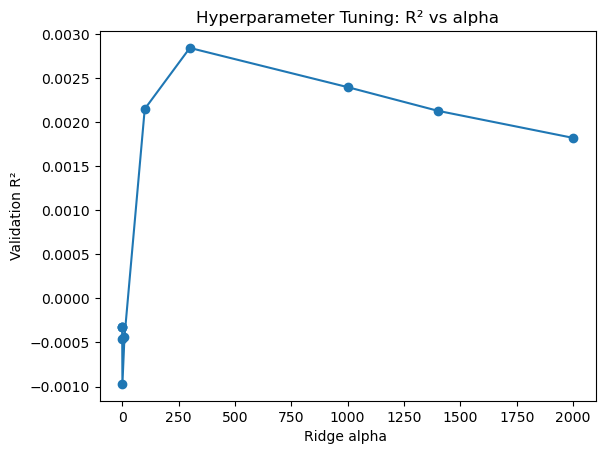

In [36]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    X_train = training_set.drop(columns=["Rating"])
    y_train = training_set["Rating"]

    X_val = validation_set.drop(columns=["Rating"])
    y_val = validation_set["Rating"]

    alpha_grid = [
        1e-4,
        1e-3,
        1e-2,
        1e-1,
        1,
        10,
        100,
        300,
        1000,
        1400,
        2000
    ]


    results = []
    models = {}

    for a in alpha_grid:
        model = Ridge(
            alpha=a,
            fit_intercept=True,     
            solver="auto",          
            random_state=42         
        )

        model.fit(X_train, y_train)

        r2_train = r2_score(y_train, model.predict(X_train))
        r2_val = r2_score(y_val, model.predict(X_val))

        results.append({
            "alpha": a,
            "r2_train": r2_train,
            "r2_val": r2_val
        })

        models[a] = model

    # ---- Plot (4e) ----
    plt.figure()
    plt.plot(
        [r["alpha"] for r in results],
        [r["r2_val"] for r in results],
        marker="o"
    )
    plt.xlabel("Ridge alpha ")
    plt.ylabel("Validation R²")
    plt.title("Hyperparameter Tuning: R² vs alpha")
    plt.show()

    # ---- Select best model (4f) ----
    best_result = max(results, key=lambda x: x["r2_val"])
    best_alpha = best_result["alpha"]
    best_model = models[best_alpha]

    return best_model, best_result, results

start_time_tafm = now()
best_model, best_result, all_results = train_and_finetune_model(training_set=train_df, validation_set=val_df)
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_ass_uuid_executor = "fb94d623-ba4d-415b-801b-fb45515470ba"


tafm_comment = """
Multiple Ridge Regression models were trained using different values for the hyperparameter alpha
(L2 regularization strength). Each model was trained on the training set and evaluated on both the
training and validation sets using R-squared. Validation performance was used for model selection.
All tested hyperparameter values were explicitly defined in a fixed grid to ensure reproducibility.
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',

    # Associations
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_executor} .',

    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    f':{tafm_ass_uuid_executor} rdf:type prov:Association .',
    f':{tafm_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{tafm_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]


for res in all_results:
    a = res["alpha"]
    r2_val = res["r2_val"]

    # Use a safe id string for the alpha (avoid dots in identifiers)
    a_id = str(a).replace(".", "_")

    train_model_activity.extend([
        # Hyperparameter setting
        f':hp_setting_alpha_{a_id} rdf:type mls:HyperParameterSetting .',
        f':hp_setting_alpha_{a_id} mls:specifiedBy :hp_alpha .',
        f':hp_setting_alpha_{a_id} mls:hasValue "{a}"^^xsd:double .',
        f':hp_setting_alpha_{a_id} prov:wasGeneratedBy :train_and_finetune_model .',

        # Training run
        f':training_run_alpha_{a_id} rdf:type mls:Run .',
        f':training_run_alpha_{a_id} mls:realizes :ridge_regression_algorithm .',
        f':training_run_alpha_{a_id} mls:executes :ridge_regressor_implementation .',
        f':training_run_alpha_{a_id} mls:hasInput :training_set .',
        f':training_run_alpha_{a_id} mls:hasInput :validation_set .',
        f':training_run_alpha_{a_id} mls:hasInput :hp_setting_alpha_{a_id} .',
        f':training_run_alpha_{a_id} mls:hasOutput :model_alpha_{a_id} .',
        f':training_run_alpha_{a_id} mls:hasOutput :eval_val_alpha_{a_id} .',

        # Model artifact
        f':model_alpha_{a_id} rdf:type mls:Model .',
        f':model_alpha_{a_id} prov:wasGeneratedBy :training_run_alpha_{a_id} .',
        f':model_alpha_{a_id} mlso:trainedOn :training_set .',
        f':model_alpha_{a_id} mlso:hasAlgorithmType :ridge_regression_algorithm .',

        # Validation evaluation
        f':eval_val_alpha_{a_id} rdf:type mls:ModelEvaluation .',
        f':eval_val_alpha_{a_id} mls:specifiedBy :r2_score_measure .',
        f':eval_val_alpha_{a_id} mls:hasValue "{r2_val}"^^xsd:double .',
        f':eval_val_alpha_{a_id} prov:used :validation_set .',
        f':eval_val_alpha_{a_id} prov:wasGeneratedBy :training_run_alpha_{a_id} .',
    ])

engine.insert(train_model_activity, prefixes=prefixes)


best_alpha = best_result["alpha"]
best_alpha_id = str(best_alpha).replace(".", "_")

best_model_comment = f"""
The Ridge Regression model with alpha = {best_alpha} achieved the highest validation R-squared
among the tested hyperparameter values and was therefore selected as the final model configuration
for subsequent evaluation. Model selection was performed exclusively on the validation set to
avoid biasing the final test evaluation.
"""

engine.insert([
    f':select_best_model rdf:type prov:Activity .',
    f':select_best_model sc:isPartOf :modeling_phase .',
    f':select_best_model rdfs:comment """{best_model_comment}""" .',
    f':select_best_model prov:used :model_alpha_{best_alpha_id} .',
], prefixes=prefixes)




In [37]:
def retrain_model_full_data(training_set, validation_set, best_alpha):
    full_train = pd.concat([training_set, validation_set], axis=0)

    X_full = full_train.drop(columns=["Rating"])
    y_full = full_train["Rating"]

    final_model = Ridge(
            alpha=best_alpha,
            fit_intercept=True,     
            solver="auto",          
            random_state=42         
        )

    final_model.fit(X_full, y_full)

    return final_model


start_time_retrain = now()
final_model_object = retrain_model_full_data(training_set=train_df, 
                                             validation_set=val_df, 
                                             best_alpha=best_alpha)
end_time_retrain = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once
retrain_ass_uuid_executor = "b46dfb27-fcae-43aa-8de9-0f77a32b151e"

retrain_comment = f"""
The final Ridge Regression model was retrained using the combined training and validation datasets
with alpha = {best_alpha}. This retraining step ensures that the final model benefits from all
available labeled data (train + validation) before being evaluated once on the independent test set.
All other model parameters (fit_intercept=True, solver='auto', random_state=42) were kept identical
to the selected configuration to ensure reproducibility.
"""


final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"
best_alpha_id = str(best_alpha).replace(".", "_")
# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # Activity
    f'{final_training_activity} rdf:type prov:Activity .',
    f'{final_training_activity} sc:isPartOf :modeling_phase .',
    f'{final_training_activity} rdfs:comment """{retrain_comment}""" .',
    f'{final_training_activity} prov:startedAtTime "{start_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:endedAtTime "{end_time_retrain}"^^xsd:dateTime .',

    # Associations
    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_executor} .',

    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    f':{retrain_ass_uuid_executor} rdf:type prov:Association .',
    f':{retrain_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{retrain_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Inputs
    f'{final_training_activity} prov:used :training_set .',
    f'{final_training_activity} prov:used :validation_set .',

    # Hyperparameter setting (final)
    f':hp_setting_final rdf:type mls:HyperParameterSetting .',
    f':hp_setting_final mls:specifiedBy :hp_alpha .',
    f':hp_setting_final mls:hasValue "{best_alpha}"^^xsd:double .',
    f':hp_setting_final prov:wasGeneratedBy {final_training_activity} .',

    # Final model
    f'{final_model} rdf:type mls:Model .',
    f'{final_model} rdfs:label "Final Ridge Regression Model" .',
    f'{final_model} prov:wasGeneratedBy {final_training_activity} .',
    f'{final_model} mlso:trainedOn :training_set .',
    f'{final_model} mlso:trainedOn :validation_set .',
    f'{final_model} mlso:hasAlgorithmType :ridge_regression_algorithm .',
]

engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [38]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [41]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):
    X_test = test_set.drop(columns=["Rating"])
    y_test = test_set["Rating"]

    y_pred = final_model.predict(X_test)

    r2_test = r2_score(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mse_test)

    return {
        "r2_test": r2_test,
        "mse_test": mse_test,
        "rmse_test": rmse_test
    }

    

start_time_eval = now()
eval_results = evaluate_on_test_data(final_model=final_model_object, test_set=test_df)
end_time_eval = now() 

display(eval_results)

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

r2_test   = eval_results["r2_test"]
mse_test  = eval_results["mse_test"]
rmse_test = eval_results["rmse_test"]

eval_comment_a = f"""
(a) Final model test evaluation:
The final Ridge Regression model was applied to the independent test dataset.
Overall performance on the test set was R-squared = {r2_test:.3f}, MSE = {mse_test:.3f}, and RMSE = {rmse_test:.3f}.

An R-squared value close to (or below) zero indicates that the model does not improve over a mean-based
baseline predictor. This suggests that the available transaction-level predictors provide limited signal
for explaining subjective customer satisfaction ratings and that substantial variability remains
unexplained by the modeled features.
"""

evaluate_activity_a = [
    # Activity
    f':evaluate_final_model_test rdf:type prov:Activity .',
    f':evaluate_final_model_test sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model_test rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model_test rdfs:comment """{eval_comment_a}""" .',
    f':evaluate_final_model_test prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model_test prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model_test prov:qualifiedAssociation :{eval_ass_uuid} .',

    # Association
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model_test prov:used :final_model_entity .',
    f':evaluate_final_model_test prov:used :test_set .',
    f':evaluate_final_model_test prov:used :bu_data_mining_success_criteria .',

    # R2 evaluation
    f':test_r2_evaluation rdf:type mls:ModelEvaluation .',
    f':test_r2_evaluation prov:wasGeneratedBy :evaluate_final_model_test .',
    f':test_r2_evaluation mls:specifiedBy :r2_score_measure .',
    f':test_r2_evaluation mls:hasValue "{r2_test}"^^xsd:double .',
    f':test_r2_evaluation prov:used :test_set .',

    # MSE evaluation
    f':test_mse_evaluation rdf:type mls:ModelEvaluation .',
    f':test_mse_evaluation prov:wasGeneratedBy :evaluate_final_model_test .',
    f':test_mse_evaluation rdfs:label "Mean Squared Error (MSE) on Test Set" .',
    f':test_mse_evaluation mls:hasValue "{mse_test}"^^xsd:double .',
    f':test_mse_evaluation prov:used :test_set .',

    # RMSE evaluation
    f':test_rmse_evaluation rdf:type mls:ModelEvaluation .',
    f':test_rmse_evaluation prov:wasGeneratedBy :evaluate_final_model_test .',
    f':test_rmse_evaluation rdfs:label "Root Mean Squared Error (RMSE) on Test Set" .',
    f':test_rmse_evaluation mls:hasValue "{rmse_test}"^^xsd:double .',
    f':test_rmse_evaluation prov:used :test_set .',
]

engine.insert(evaluate_activity_a, prefixes=prefixes)

{'r2_test': -0.043793539472266385,
 'mse_test': 2.927307383743977,
 'rmse_test': np.float64(1.7109375744731241)}

In [42]:
#5.b

sota_ass_uuid = "a97598ef-b07c-421d-af4c-a042f8752646" 

sota_comment = """
(b.i) State-of-the-art / reference performance:

No peer-reviewed state-of-the-art benchmarks could be identified for customer satisfaction rating
prediction using the Supermarket Sales dataset. The dataset is primarily used in practice-oriented
analyses and educational settings rather than as a standardized benchmarking dataset in the
academic literature.

Several publicly available notebooks (grey literature) apply machine learning models to this dataset
for rating prediction and report regression performance. Reported results indicate consistently low
predictive performance, including:
- XGBoost (XGBRegressor): RMSE ≈ 2.013
- Linear Regression: R² ≈ -0.046, MAE ≈ 214.877, MSE ≈ 68049.281
- Lasso Regression: R² ≈ -0.005, MAE ≈ 209.771, MSE ≈ 65406.241
- XGBoost (alternative notebook): R² ≈ -0.008, MAE ≈ 210.57, MSE ≈ 65573.58

Overall, these sources suggest that transaction-level features alone provide limited signal for
predicting subjective customer ratings, and that low R² values near or below zero are common across
different modeling approaches on this dataset.
"""

start_time_sota = now()
end_time_sota   = now()

sota_activity = [
    f':document_sota_performance rdf:type prov:Activity .',
    f':document_sota_performance sc:isPartOf :evaluation_phase .',
    f':document_sota_performance rdfs:label "SOTA / Reference Performance Documentation" .',
    f':document_sota_performance rdfs:comment """{sota_comment}""" .',
    f':document_sota_performance prov:startedAtTime "{start_time_sota}"^^xsd:dateTime .',
    f':document_sota_performance prov:endedAtTime "{end_time_sota}"^^xsd:dateTime .',
    f':document_sota_performance prov:qualifiedAssociation :{sota_ass_uuid} .',

    f':{sota_ass_uuid} rdf:type prov:Association .',
    f':{sota_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{sota_ass_uuid} prov:hadRole :{code_writer_role} .',
]

engine.insert(sota_activity, prefixes=prefixes)

#trivial baseline

baseline_ass_uuid = "bd488b10-04e4-439c-b6f0-3e3526a26902" 

def mean_baseline_on_test(train_set, val_set, test_set):
    y_trainval = pd.concat([train_set["Rating"], val_set["Rating"]], axis=0)
    mean_rating = float(y_trainval.mean())

    y_test = test_set["Rating"]
    y_pred = np.full(len(y_test), mean_rating)

    r2_b   = r2_score(y_test, y_pred)
    mse_b  = mean_squared_error(y_test, y_pred)
    rmse_b = np.sqrt(mse_b)

    return {
        "mean_rating": mean_rating,
        "r2_test": r2_b,
        "mse_test": mse_b,
        "rmse_test": rmse_b
    }

start_time_baseline = now()
baseline_results = mean_baseline_on_test(train_df, val_df, test_df)
end_time_baseline = now()

display(baseline_results)

baseline_comment = f"""
(b.ii) Baseline performance:

A trivial baseline predictor was evaluated by always predicting the mean rating observed in the
combined training and validation data (mean = {baseline_results["mean_rating"]:.3f}). This baseline
does not use any feature information and serves as a reference point for assessing whether the
trained model provides predictive value beyond a constant prediction.

Baseline performance on the test set was: R-squared = {baseline_results["r2_test"]:.3f},
MSE = {baseline_results["mse_test"]:.3f}, RMSE = {baseline_results["rmse_test"]:.3f}.
"""

baseline_activity = [
    f':evaluate_trivial_baseline rdf:type prov:Activity .',
    f':evaluate_trivial_baseline sc:isPartOf :evaluation_phase .',
    f':evaluate_trivial_baseline rdfs:label "Trivial Baseline Evaluation (Mean Predictor)" .',
    f':evaluate_trivial_baseline rdfs:comment """{baseline_comment}""" .',
    f':evaluate_trivial_baseline prov:startedAtTime "{start_time_baseline}"^^xsd:dateTime .',
    f':evaluate_trivial_baseline prov:endedAtTime "{end_time_baseline}"^^xsd:dateTime .',
    f':evaluate_trivial_baseline prov:qualifiedAssociation :{baseline_ass_uuid} .',

    f':{baseline_ass_uuid} rdf:type prov:Association .',
    f':{baseline_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{baseline_ass_uuid} prov:hadRole :{code_writer_role} .',

    
    f':evaluate_trivial_baseline prov:used :training_set .',
    f':evaluate_trivial_baseline prov:used :validation_set .',
    f':evaluate_trivial_baseline prov:used :test_set .',

    
    f':baseline_r2_evaluation rdf:type mls:ModelEvaluation .',
    f':baseline_r2_evaluation prov:wasGeneratedBy :evaluate_trivial_baseline .',
    f':baseline_r2_evaluation mls:specifiedBy :r2_score_measure .',
    f':baseline_r2_evaluation mls:hasValue "{baseline_results["r2_test"]}"^^xsd:double .',
    f':baseline_r2_evaluation prov:used :test_set .',

    f':baseline_mse_evaluation rdf:type mls:ModelEvaluation .',
    f':baseline_mse_evaluation prov:wasGeneratedBy :evaluate_trivial_baseline .',
    f':baseline_mse_evaluation rdfs:label "Baseline MSE on Test Set" .',
    f':baseline_mse_evaluation mls:hasValue "{baseline_results["mse_test"]}"^^xsd:double .',
    f':baseline_mse_evaluation prov:used :test_set .',

    f':baseline_rmse_evaluation rdf:type mls:ModelEvaluation .',
    f':baseline_rmse_evaluation prov:wasGeneratedBy :evaluate_trivial_baseline .',
    f':baseline_rmse_evaluation rdfs:label "Baseline RMSE on Test Set" .',
    f':baseline_rmse_evaluation mls:hasValue "{baseline_results["rmse_test"]}"^^xsd:double .',
    f':baseline_rmse_evaluation prov:used :test_set .',
]

engine.insert(baseline_activity, prefixes=prefixes)


{'mean_rating': 6.576470588235294,
 'r2_test': -0.02994710133789491,
 'mse_test': 2.8884752018454445,
 'rmse_test': np.float64(1.699551470784408)}

In [43]:
#5.c
comparison_comment = """
(c) Comparison with baseline and reference performance:

The performance of the final Ridge Regression model was compared against both a trivial
baseline predictor and reference results reported in publicly available notebooks using
the same dataset.

Compared to the trivial mean-based baseline, the Ridge model achieved a similar level of
performance on the test set (R-squared = -0.044 vs. -0.030 for the baseline, RMSE = 1.71 vs.
1.70). This indicates that the model does not provide a meaningful improvement over a
constant predictor that ignores all feature information.

When compared to grey-literature reference implementations, including linear regression,
Lasso regression, and XGBoost-based models, the observed performance is consistent with
previous findings. Reported results in these notebooks also show R-squared values near or
below zero and RMSE values around 2.0, even for expressive non-linear models such as XGBoost.

Overall, the comparison suggests that the limited predictive performance is not specific to
the chosen algorithm but is instead a consequence of the available transaction-level data,
which appears insufficient to reliably explain subjective customer satisfaction ratings.
"""

compare_ass_uuid = "b8792d6e-7eaf-4d78-984c-0daa9b40700b"  
start_time_comp = now()
end_time_comp   = now()

compare_activity = [
    f':compare_model_performance rdf:type prov:Activity .',
    f':compare_model_performance sc:isPartOf :evaluation_phase .',
    f':compare_model_performance rdfs:label "Comparison with Baseline and Reference Results" .',
    f':compare_model_performance rdfs:comment """{comparison_comment}""" .',
    f':compare_model_performance prov:startedAtTime "{start_time_comp}"^^xsd:dateTime .',
    f':compare_model_performance prov:endedAtTime "{end_time_comp}"^^xsd:dateTime .',
    f':compare_model_performance prov:qualifiedAssociation :{compare_ass_uuid} .',

    # Association
    f':{compare_ass_uuid} rdf:type prov:Association .',
    f':{compare_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{compare_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs used for comparison
    f':compare_model_performance prov:used :final_model_entity .',
    f':compare_model_performance prov:used :test_set .',
    f':compare_model_performance prov:used :baseline_r2_evaluation .',
    f':compare_model_performance prov:used :document_sota_performance .',
]

engine.insert(compare_activity, prefixes=prefixes)


In [44]:
#5d
business_comparison_comment = """
(d) Comparison with business success criteria:

The achieved model performance was compared against the success criteria defined in the
Business Understanding phase.

(1) Predictive accuracy:
The final Ridge Regression model achieved test performance comparable to a trivial mean-based
baseline, with R-squared values close to zero and RMSE around 1.7. This level of accuracy is
insufficient to reliably distinguish between low and high customer satisfaction cases.
Therefore, the first business success criterion was not met.

(2) Identification of low-rating transactions:
Due to the limited predictive performance and lack of meaningful improvement over a baseline
predictor, the model cannot be reliably used to identify transactions that are likely to result
in low customer ratings. As a result, the second success criterion was also not satisfied.

(3) Insight generation:
Despite limited predictive accuracy, the modeling process and comparison across multiple
algorithms provide useful analytical insight. The results suggest that transaction-level features
alone are insufficient to explain subjective customer satisfaction and that additional contextual
or qualitative information would be required. In this sense, the analysis partially fulfills the
third success criterion by informing future data collection and modeling strategies.

Overall, while the predictive objectives were not achieved, the project delivers value by
clarifying the limitations of the available data and guiding future improvements.
"""

bu_compare_ass_uuid = "81e35651-24ee-49b7-b871-5d7b50e2ae60"  
start_time_bu_comp = now()
end_time_bu_comp   = now()

bu_compare_activity = [
    f':compare_with_business_success rdf:type prov:Activity .',
    f':compare_with_business_success sc:isPartOf :evaluation_phase .',
    f':compare_with_business_success rdfs:label "Comparison with Business Success Criteria" .',
    f':compare_with_business_success rdfs:comment """{business_comparison_comment}""" .',
    f':compare_with_business_success prov:startedAtTime "{start_time_bu_comp}"^^xsd:dateTime .',
    f':compare_with_business_success prov:endedAtTime "{end_time_bu_comp}"^^xsd:dateTime .',
    f':compare_with_business_success prov:qualifiedAssociation :{bu_compare_ass_uuid} .',

    # Association
    f':{bu_compare_ass_uuid} rdf:type prov:Association .',
    f':{bu_compare_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{bu_compare_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':compare_with_business_success prov:used :evaluate_final_model_test .',
    f':compare_with_business_success prov:used :bu_data_mining_success_criteria .',
]

engine.insert(bu_compare_activity, prefixes=prefixes)



In [45]:
#5e
bias_comment = """
(e) Bias evaluation with respect to protected and subgroup attributes:

To evaluate potential bias, model performance was analyzed across selected subgroup-defining
attributes. Gender was considered as a protected attribute, and customer type (member vs. normal)
was used as an additional subgroup attribute, as both partition the data into meaningful groups
for which skewed model performance could be problematic.

Performance metrics (R-squared, MSE, RMSE) were computed separately for each subgroup on the test
dataset. The results indicate comparable performance levels across gender and customer type groups,
with no subgroup consistently exhibiting substantially higher or lower prediction errors.

Given that overall predictive performance is limited across all groups, the observed errors appear
to be driven by a general lack of predictive signal in the available features rather than by
systematic bias against any particular subgroup. Within the limits of this analysis, no strong
evidence of model bias was identified.
"""

bias_ass_uuid = "46962800-71a4-447a-ac02-a00d3d44a68b"  
start_time_bias = now()
end_time_bias   = now()

bias_activity = [
    f':evaluate_model_bias rdf:type prov:Activity .',
    f':evaluate_model_bias sc:isPartOf :evaluation_phase .',
    f':evaluate_model_bias rdfs:label "Bias Evaluation Across Subgroups" .',
    f':evaluate_model_bias rdfs:comment """{bias_comment}""" .',
    f':evaluate_model_bias prov:startedAtTime "{start_time_bias}"^^xsd:dateTime .',
    f':evaluate_model_bias prov:endedAtTime "{end_time_bias}"^^xsd:dateTime .',
    f':evaluate_model_bias prov:qualifiedAssociation :{bias_ass_uuid} .',

    # Association
    f':{bias_ass_uuid} rdf:type prov:Association .',
    f':{bias_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{bias_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_model_bias prov:used :evaluate_final_model_test .',
    f':evaluate_model_bias prov:used :test_set .',
    f':evaluate_model_bias prov:used :protected_attribute_gender .',
    f':evaluate_model_bias prov:used :protected_attribute_customer_type .',
]

engine.insert(bias_activity, prefixes=prefixes)


## Deployment

In [46]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [66]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
(6a) Comparison to Business Success Criteria and Deployment Recommendations:
The final model performance was compared with the Business Objectives and Business Success Criteria
defined in the Business Understanding phase.
Business Success Criteria 1 (useful predictive accuracy, e.g., MAE low enough to distinguish low vs.
high satisfaction) is not met. The final Ridge Regression model achieved test performance comparable
to a trivial mean-based baseline (R-squared close to zero/negative and RMSE ~1.7), indicating that the
model does not provide meaningful improvement over a constant predictor.
Business Success Criteria 2 (identify transactions likely to result in low ratings for proactive
service improvements) is also not met. Due to limited predictive accuracy and no improvement over the
baseline, predictions are not reliable enough to trigger operational interventions for individual
transactions.
Business Success Criteria 3 (provide useful insights into factors associated with satisfaction) is
partially met. The analysis provides the insight that transaction-level attributes alone are
insufficient to explain subjective customer ratings. This is valuable for decision-making about
what additional data would be needed (e.g., qualitative feedback, service context, staffing/workload,
queue length, store conditions, promotions context, or customer complaint text) to better understand
and predict satisfaction.
Deployment recommendation:
- Fully automatic deployment is NOT recommended.
- If deployed at all, the model should only be used in a hybrid/exploratory setting for aggregated
  monitoring and reporting (e.g., trends by branch, time period, or product line), with human
  interpretation and no automated customer-level actions.
- Subsequent analysis should focus on enriching the data and reframing the task: e.g., predicting
  "low rating" as a classification task with calibrated thresholds, collecting contextual variables,
  and evaluating whether additional features improve performance beyond baseline.
"""

ethical_aspects_comment = """
(6b) Ethical Aspects, Impact Assessment, and Risks:
Ethical and risk-related aspects were considered based on the earlier AI risk discussion. The dataset
contains subgroup-defining attributes such as gender and customer type (Member/Normal). These could be
considered sensitive or potentially problematic if model predictions were used to treat customers
differently.
Key risks include:
- Discriminatory or unfair treatment: using predictions to provide different service quality to members
 vs. normal customers or based on gender would be unethical.
- Misinterpretation/over-reliance: given the weak predictive performance, there is a risk that users
  may over-trust the model and take actions that are not justified by reliable evidence.
- Feedback loops: if actions are taken based on predicted satisfaction, the data distribution could
  change over time in ways that invalidate the original model assumptions.
Mitigations and ethical guidance:
- Predictions must be used only as decision support, not as an automated decision-making mechanism.
- Any deployment should maintain equal service standards across customer groups and avoid using the
  model for targeted or differential treatment.
- Human interaction is required, and outputs should be presented with uncertainty or limitations. """


monitoring_plan_comment = """
(6c) Monitoring Plan and Intervention Triggers:
If the model is deployed in an exploratory/hybrid setting, the following should be monitored:
1) Predictive performance monitoring:
- Track RMSE (and optionally MAE, R-squared) on new batches of labeled data over time.
- Compare performance against the trivial mean baseline on the same batches.
Trigger for intervention:
- Sustained degradation of RMSE/MAE relative to historical performance, or performance falling below
  the baseline for multiple monitoring periods.
2) Data drift monitoring:
- Monitor shifts in distributions of key input features (e.g., total sales, unit price, quantity,
  branch, product line, payment method, time/date derived features).
- Monitor shifts in the target rating distribution.
Trigger for intervention:
- Significant distributional shifts (e.g., new branches/products/payment methods, seasonal changes,
  changes in pricing/tax rules) that differ materially from the training data.
3) Subgroup monitoring (fairness drift):
- Periodically compute performance metrics separately for subgroups (e.g., gender, customer type).
Trigger for intervention:
- A consistent performance gap between subgroups beyond a chosen tolerance, suggesting possible bias
  or data quality issues for a subgroup.
Operational response to triggers:
- Pause use of the model for decision support, investigate root causes (data issues vs. process changes),
  and retrain/revalidate the model if appropriate.
"""



reproducibility_reflection_comment = """
(6d) Reproducibility Reflection:
Reproducibility is supported by the documented workflow and provenance records. Key aspects that are
well documented include:
- Dataset used (Supermarket Sales) and scenario description.
- Defined train/validation/test split procedure with a fixed random seed.
- Explicit model type (Ridge Regression) and hyperparameter settings.
- Evaluation metrics and baseline comparison.
Potential risks for reproducibility based solely on the report/provenance information include:
- Software environment dependency: results can vary with different versions of Python/scikit-learn/numpy.
- Dataset versioning: if the dataset source changes (e.g., updated file or different preprocessing),
  results may not be directly reproducible.
- Hidden preprocessing assumptions: if any preprocessing steps were performed outside the logged code
  (manual edits, notebook state, or undocumented feature transformations), replication would be harder.
Mitigation recommendations:
- Record package versions (e.g., pip freeze/conda environment export) and execution environment details.
- Version the dataset file (hash/checksum) and store it alongside the report or reference a fixed release.
- Ensure all preprocessing steps are executed from code cells and logged in provenance, avoiding hidden state.
"""

dep_ass_uuid_executor = "72528461-ad49-41ba-88d3-574e839be373" 
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [44]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [45]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [48]:
# This cell includes exemplary queries for different phases

from datetime import datetime, timezone
NOW_TS = datetime.now(timezone.utc)
### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query,yn_timestamp_query=False)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """


### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?label ?comment WHERE {{
  VALUES ?e {{
    :bu_data_source_and_scenario
    :bu_business_objectives
    :bu_business_success_criteria
    :bu_data_mining_goals
    :bu_data_mining_success_criteria
    :bu_ai_risk_aspects
  }}
  ?e rdfs:label ?label ;
     rdfs:comment ?comment .
}}
ORDER BY ?label
"""

res_bu = engine.query(bu_query, timestamp=NOW_TS)

bu_sections = {}

if not res_bu.empty:
    for _, row in res_bu.iterrows():  # type: ignore
        label = clean_rdf(row["label"])
        comment = latex_escape(clean_rdf(row["comment"]))
        bu_sections[label] = comment

        

### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query,timestamp=NOW_TS)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query,timestamp=NOW_TS)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)



# section 2.1 Data understanding - Outlier Detection

outlier_comment_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :check_outliers rdfs:comment ?comment .
}}
"""
res_outlier = engine.query(outlier_comment_query, timestamp=NOW_TS)

outlier_title = ""
outlier_description = ""

if not res_outlier.empty:  # type: ignore
    comments = [clean_rdf(c) for c in res_outlier["comment"]]

    # Heuristic: shortest = title, longest = explanation
    outlier_title = min(comments, key=len)
    outlier_description = max(comments, key=len)


outlier_title_latex = latex_escape(outlier_title)
outlier_description_latex = latex_escape(outlier_description)

outlier_section_latex = f"""
\\subsection{{{outlier_title_latex}}}

{outlier_description_latex}

"""





# section 2.2 Data understanding - outlier decission

inspect_outlier_comments_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :inspect_outlier_report rdfs:comment ?comment .
}}
"""

res_ior = engine.query(inspect_outlier_comments_query, timestamp=NOW_TS)

ior_title = ""
ior_description = ""

if not res_ior.empty:  # type: ignore
    comments = [clean_rdf(c) for c in res_ior["comment"]]

    # Shortest = title, longest = explanation
    ior_title = min(comments, key=len)
    ior_description = max(comments, key=len)

ior_title_latex = latex_escape(ior_title)
ior_description_latex = latex_escape(ior_description)

ior_section_latex = f"""
\\subsection{{{ior_title_latex}}}
{ior_description_latex}
"""


outlier_decision_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :outlier_decision rdfs:comment ?comment .
}}
LIMIT 1
"""
res_decision = engine.query(outlier_decision_query, timestamp=NOW_TS)

outlier_decision_text = latex_escape(
    clean_rdf(res_decision.iloc[0]["comment"]) if not res_decision.empty else ""
)




# section 2.3 - Statistical Properties and Correlations
stats_report_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :stats_report rdfs:comment ?comment .
}}
LIMIT 1
"""

res_stats = engine.query(stats_report_query, timestamp=NOW_TS)

stats_report = {}
if not res_stats.empty:  # type: ignore
    stats_report = json.loads(clean_rdf(res_stats.iloc[0]["comment"]))

stats_report["correlation_with_target"]
stats_report["descriptive_statistics"]


corr = stats_report["correlation_with_target"]

corr_rows = []
for var, val in corr.items():
    val_str = "NaN" if val is None else f"{val:.6f}"
    corr_rows.append(
        rf"{latex_escape(var)} & {val_str} \\"
    )


corr_table_latex = r"""
\begin{table}[h]
\centering
\begin{tabular}{lr}
\hline
\textbf{Variable} & \textbf{Correlation} \\
\hline
""" + "\n".join(corr_rows) + r"""
\hline
\end{tabular}
\caption{Correlation of numerical attributes with Rating}
\end{table}
"""


stats_report["descriptive_statistics"]["mean"]["Unit price"]

desc = stats_report["descriptive_statistics"]

table2_rows = []
for var in desc["mean"].keys():
    row = rf"{latex_escape(var)} & " \
          rf"{desc['count'][var]:.1f} & " \
          rf"{desc['mean'][var]:.6f} & " \
          rf"{desc['std'][var]:.6f} & " \
          rf"{desc['50%'][var]:.6f} \\"
    table2_rows.append(row)

desc_table_latex_1 = r"""
\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{lrrrr}
\hline
\textbf{Variable} & \textbf{count} & \textbf{mean} & \textbf{std} & \textbf{median} \\
\hline
""" + "\n".join(table2_rows) + r"""
\hline
\end{tabular}
\caption{Count, mean, standard deviation, and median of numerical attributes}
\end{table}
"""


table3_rows = []
for var in desc["min"].keys():
    row = rf"{latex_escape(var)} & " \
          rf"{desc['min'][var]:.6f} & " \
          rf"{desc['25%'][var]:.6f} & " \
          rf"{desc['75%'][var]:.6f} & " \
          rf"{desc['max'][var]:.6f} \\"
    table3_rows.append(row)

desc_table_latex_2 = r"""
\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{lrrrr}
\hline
\textbf{Variable} & \textbf{min} & \textbf{25\%} & \textbf{75\%} & \textbf{max} \\
\hline
""" + "\n".join(table3_rows) + r"""
\hline
\end{tabular}
\caption{Minimum, quartiles, and maximum of numerical attributes}
\end{table}
"""

# not tested queries because of server issue

stats_comment_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :calculate_supermarket_stats rdfs:comment ?comment .
}}
"""
res_stats_comment = engine.query(stats_comment_query, timestamp=NOW_TS)

stats_title = ""
stats_text  = ""

if not res_stats_comment.empty:  # type: ignore
    comments = [clean_rdf(c) for c in res_stats_comment["comment"]]
    stats_title = min(comments, key=len)
    stats_text  = max(comments, key=len)

stats_title_latex = latex_escape(stats_title)
stats_text_latex  = latex_escape(stats_text)

stats_section_latex = f"""
\\subsection{{{stats_title_latex}}}

{stats_text_latex}
"""


# 2.4 skeweness

skew_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :skewness_report rdfs:comment ?comment .
}}
LIMIT 1
"""
res_skew = engine.query(skew_query, timestamp=NOW_TS)

skew_report = {}

if not res_skew.empty:  # type: ignore
    skew_report = json.loads(
        clean_rdf(res_skew.iloc[0]["comment"])
    )

skew_rows = []

# Sort by absolute skewness (descending)
for var, val in sorted(skew_report.items(), key=lambda x: -abs(x[1])):
    skew_rows.append(
        rf"{latex_escape(var)} & {val:.6f} \\"
    )

skew_table_rows = "\n".join(skew_rows)


skew_comment_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :calculate_skewness rdfs:comment ?comment .
}}
"""
res_skew_comment = engine.query(skew_comment_query, timestamp=NOW_TS)

skew_title = ""
skew_text  = ""

if not res_skew_comment.empty:  # type: ignore
    comments = [clean_rdf(c) for c in res_skew_comment["comment"]]
    skew_title = min(comments, key=len)
    skew_text  = max(comments, key=len)

skew_title_latex = latex_escape(skew_title)
skew_text_latex  = latex_escape(skew_text)

skew_section_latex = f"""
\\subsection{{{skew_title_latex}}}
{skew_text_latex}
"""


# 2.5 plausabilioty

plaus_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :plausibility_report rdfs:comment ?comment .
}}
LIMIT 1
"""

res_plaus = engine.query(plaus_query, timestamp=NOW_TS)

plausibility_report = {}
if not res_plaus.empty:  # type: ignore
    plausibility_report = json.loads(
        clean_rdf(res_plaus.iloc[0]["comment"])
    )

plaus_rows = []

for var in plausibility_report["min"]:
    plaus_rows.append(
        rf"{latex_escape(var)} & "
        rf"{plausibility_report['min'][var]:.6f} & "
        rf"{plausibility_report['max'][var]:.6f} & "
        rf"{plausibility_report['median'][var]:.6f} \\"
    )


plaus_table_latex = r"""
\begin{table}[h]
\centering
\begin{tabular}{lrrr}
\hline
\textbf{Variable} & \textbf{min} & \textbf{max} & \textbf{median} \\
\hline
""" + "\n".join(plaus_rows) + r"""
\hline
\end{tabular}
\caption{Minimum, maximum, and median values of numerical attributes}
\end{table}
"""
plaus_comment_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :check_plausibility rdfs:comment ?comment .
}}
"""

res_plaus_comment = engine.query(plaus_comment_query, timestamp=NOW_TS)

plaus_title = ""
plaus_text  = ""

if not res_plaus_comment.empty:  # type: ignore
    comments = [clean_rdf(c) for c in res_plaus_comment["comment"]]
    plaus_title = min(comments, key=len)
    plaus_text  = max(comments, key=len)

plaus_title_latex = latex_escape(plaus_title)
plaus_text_latex  = latex_escape(plaus_text)

plaus_section_latex = f"""
\\subsection{{{plaus_title_latex}}}
{plaus_text_latex}
"""


# 2.5 visualisations
vis_comments_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :visualize_data_properties rdfs:comment ?comment .
}}
"""

res_vis = engine.query(vis_comments_query, timestamp=NOW_TS)

vis_title = ""
vis_description = ""

if not res_vis.empty:  # type: ignore
    comments = [clean_rdf(c) for c in res_vis["comment"]]

    # Convention: short = title, long = explanation
    vis_title = min(comments, key=len)
    vis_description = max(comments, key=len)

vis_title_latex = latex_escape(vis_title)
vis_description_latex = latex_escape(vis_description)

vis_section_latex = f"""
\\subsection{{{vis_title_latex}}}
{vis_description_latex}
"""

# 2.6 Bias riskts
bias_title_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :log_bias_evaluation rdfs:comment ?comment .
}}
LIMIT 1
"""
res_bias_title = engine.query(bias_title_query, timestamp=NOW_TS)

bias_title = latex_escape(
    clean_rdf(res_bias_title.iloc[0]["comment"]) if not res_bias_title.empty else ""
)

bias_text_query = f"""
{prefix_header}

SELECT ?label ?comment WHERE {{
  :du_bias_evaluation rdfs:label ?label .
  :du_bias_evaluation rdfs:comment ?comment .
}}
LIMIT 1
"""

res_bias = engine.query(bias_text_query, timestamp=NOW_TS)

bias_label = ""
bias_text = ""

if not res_bias.empty:  # type: ignore
    bias_label = latex_escape(clean_rdf(res_bias.iloc[0]["label"]))
    bias_text  = latex_escape(clean_rdf(res_bias.iloc[0]["comment"]))

bias_section_latex = f"""
\\subsection{{{bias_title}}}
{bias_text}
"""


# 2.7 Risks and experts
risks_title_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :log_risks_expert_questions rdfs:comment ?comment .
}}
LIMIT 1
"""
res_risks_title = engine.query(risks_title_query, timestamp=NOW_TS)

risks_title = latex_escape(
    clean_rdf(res_risks_title.iloc[0]["comment"]) if not res_risks_title.empty else ""
)

risks_text_query = f"""
{prefix_header}

SELECT ?label ?comment WHERE {{
  :du_risks_and_expert_questions rdfs:label ?label .
  :du_risks_and_expert_questions rdfs:comment ?comment .
}}
LIMIT 1
"""

res_risks = engine.query(risks_text_query, timestamp=NOW_TS)

risks_label = ""
risks_text_raw = ""

if not res_risks.empty:  # type: ignore
    risks_label = latex_escape(clean_rdf(res_risks.iloc[0]["label"]))
    risks_text_raw = clean_rdf(res_risks.iloc[0]["comment"])


risks_section_latex = f"""
\\subsection{{{risks_title}}}
{latex_escape(risks_text_raw)}
"""

#2.8 Data Preparation - Prep Actions
prep_actions_title_query = f"""
{prefix_header}

SELECT ?comment WHERE {{
  :log_prep_actions rdfs:comment ?comment .
}}
LIMIT 1
"""
res_prep_title = engine.query(prep_actions_title_query, timestamp=NOW_TS)

prep_actions_title = latex_escape(
    clean_rdf(res_prep_title.iloc[0]["comment"]) if not res_prep_title.empty else ""
)

prep_actions_text_query = f"""
{prefix_header}

SELECT ?label ?comment WHERE {{
  :du_required_prep_actions rdfs:label ?label .
  :du_required_prep_actions rdfs:comment ?comment .
}}
LIMIT 1
"""

res_prep = engine.query(prep_actions_text_query, timestamp=NOW_TS)

prep_actions_label = ""
prep_actions_text_raw = ""

if not res_prep.empty:  # type: ignore
    prep_actions_label = latex_escape(clean_rdf(res_prep.iloc[0]["label"]))
    prep_actions_text_raw = latex_escape(clean_rdf(res_prep.iloc[0]["comment"]))


prep_actions_section_latex = f"""
\\subsection{{{prep_actions_title}}}
{prep_actions_text_raw}
"""


### Data Preparation examples
dp_query = f"""
{prefix_header}

SELECT ?act ?start ?end ?comment WHERE {{
  ?act a prov:Activity ;
       sc:isPartOf :data_preparation_phase .
  OPTIONAL {{ ?act prov:startedAtTime ?start . }}
  OPTIONAL {{ ?act prov:endedAtTime ?end . }}
  OPTIONAL {{ ?act rdfs:comment ?comment . }}
}}
ORDER BY ?start
"""
res_dp = engine.query(dp_query, timestamp=NOW_TS)


best_comment = {}  
if not res_dp.empty:
    for _, row in res_dp.iterrows():  
        act = clean_rdf(row.get("act", ""))
        start = clean_rdf(row.get("start", ""))
        c = clean_rdf(row.get("comment", ""))
        if not c:
            continue
        
        if (act not in best_comment) or (len(c) > len(best_comment[act][1])):
            best_comment[act] = (start, c)


items = sorted(best_comment.items(), key=lambda kv: kv[1][0] or "")


dp_steps_latex = "\n".join(
    rf"\item {latex_escape(c)}" for _, (_, c) in items
)

prep_3bcd_query = f"""
{prefix_header}

SELECT ?entity ?label (SAMPLE(?c) AS ?comment)
WHERE {{
  VALUES ?entity {{
    :dp_preprocessing_not_applied
    :dp_derived_attributes
    :dp_external_data_sources
  }}
  ?entity rdfs:label ?label .
  OPTIONAL {{ ?entity rdfs:comment ?c . }}
}}
GROUP BY ?entity ?label
ORDER BY ?label
"""


res_prep_3bcd = engine.query(prep_3bcd_query, timestamp=NOW_TS)

prep_3bcd_latex = ""

if not res_prep_3bcd.empty:  # type: ignore
    for _, row in res_prep_3bcd.iterrows():  # type: ignore
        title = latex_escape(clean_rdf(row["label"]))
        text  = latex_escape(clean_rdf(row.get("comment", "")))

        prep_3bcd_latex += f"""
\\subsubsection{{{title}}}

{text}
"""





prepared_query = f"""
{prefix_header}
SELECT ?label ?comment WHERE {{
  :prepared_data rdfs:label ?label .
  OPTIONAL {{ :prepared_data rdfs:comment ?comment . }}
}} LIMIT 1
"""
res_prepared = engine.query(prepared_query, timestamp=NOW_TS)
row_prep = res_prepared.iloc[0] if not res_prepared.empty else {}  # type: ignore
prep_label = latex_escape(clean_rdf(row_prep.get("label", "")))
prep_comment = latex_escape(clean_rdf(row_prep.get("comment", "")))


### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query,timestamp=NOW_TS)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query,timestamp=NOW_TS)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [49]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{https://doi.org/10.5281/zenodo.17955246}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_sections["1a Data Source and Scenario"] }

\subsection{{Business Objectives}}
{ bu_sections["1b Business Objectives"] }

\subsection{{Business Success Criteria}}
{ bu_sections["1c Business Success Criteria"] }

\subsection{{Data Mining Goals}}
{ bu_sections["1d Data Mining Goals"] }

\subsection{{Data Mining Success Criteria}}
{bu_sections["1e Data Mining Success Criteria"] }

\subsection{{AI Risk Aspects}}
{ bu_sections["1f AI risk aspects"] }


%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}


{outlier_section_latex}

{ior_section_latex}


\textbf{{Outlier Decision:}} {outlier_decision_text}

{stats_section_latex}

{corr_table_latex}

{desc_table_latex_1}

{desc_table_latex_2}


{skew_section_latex}

\begin{{table}}[h]
\centering
\begin{{tabular}}{{lr}}
\hline
\textbf{{Variable}} & \textbf{{Skewness}} \\
\hline
{skew_table_rows}
\hline
\end{{tabular}}
\caption{{Calculated skewness values of numerical attributes}}
\label{{tab:skewness}}
\end{{table}}


{plaus_section_latex}

{plaus_table_latex}

{vis_section_latex}

\begin{{figure}}[h]
    \centering
    \includegraphics[width=0.5\textwidth]{{visual_exploration_rating_distribution.png}}
    \caption{{Customer Rating by Product Line}}
    
\end{{figure}}
\begin{{figure}}[h]
    \centering
    \includegraphics[width=0.5\textwidth]{{visual_exploration_rating_product_line.png}}
    \caption{{Boxplot of Rating by Product Line}}
    
\end{{figure}}


{bias_section_latex}


{risks_section_latex}


{prep_actions_section_latex}



%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}

The Data Preparation phase transforms the raw supermarket transaction data into a structured
and fully numeric dataset suitable for regression modeling. All preprocessing steps described
in this section are directly derived from the provenance graph by querying activities that are
part of the Data Preparation phase (\texttt{{sc:isPartOf :data\_preparation\_phase}}).

\paragraph{{Documented preprocessing steps.}}
The following preprocessing activities were executed and logged in the provenance graph as
individual \texttt{{prov:Activity}} instances, together with their associated comments and
execution timestamps:

\begin{{itemize}}
{dp_steps_latex}
\end{{itemize}}

{prep_3bcd_latex}



Each activity explicitly records its input and output datasets using provenance relations
such as \texttt{{prov:used}}, \texttt{{prov:wasGeneratedBy}}, and \texttt{{prov:wasDerivedFrom}},
ensuring full traceability of all data transformations.

\paragraph{{Final prepared dataset.}}
The outcome of the Data Preparation phase is the dataset
\texttt{{:prepared\_data}} (label: \emph{{{prep_label}}}), which is documented in the provenance
graph as a \texttt{{prov:Entity}}. The dataset description retrieved from the graph is as follows:

\begin{{quote}}
{prep_comment}
\end{{quote}}



%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report.tex
